## Genetic Disorder Prediction and Classification

#### About the project
The project is based on [HackerEarth Machine Learning Challenge](https://www.kaggle.com/datasets/imsparsh/of-genomes-and-genetics-hackerearth-ml?select=sample_submission.csv). The task was to predit genetics disorder and disorder subclass based on medical information about children who suffer from genetic disorders.This notebook will focus on some of the exploratory data analysis (EDA)

## Imports

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sys
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, TargetEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.base import clone
#import category_encoders as ce
import time
import collections
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import math
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pathlib import Path
import os
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import KFold
#from category_encoders import TargetEncoder


In [4]:
genetic_df = pd.read_csv('data/genetic_disorder.csv')
genetic_df.head()

,Patient Id,Patient Age,Genes in mother's side,Inherited from father,Maternal gene,Paternal gene,Blood cell count (mcL),Patient First Name,Family Name,Father's name,...,Birth defects,White Blood cell count (thousand per microliter),Blood test result,Symptom 1,Symptom 2,Symptom 3,Symptom 4,Symptom 5,Genetic Disorder,Disorder Subclass
0,PID0x6418,2.0,Yes,No,Yes,No,4.760603,Richard,NaN,Larre,...,NaN,9.857562,NaN,1.0,1.0,1.0,1.0,1.0,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy
1,PID0x25d5,4.0,Yes,Yes,No,No,4.910669,Mike,NaN,Brycen,...,Multiple,5.522560,normal,1.0,NaN,1.0,1.0,0.0,NaN,Cystic fibrosis
2,PID0x4a82,6.0,Yes,No,No,No,4.893297,Kimberly,NaN,Nashon,...,Singular,NaN,normal,0.0,1.0,1.0,1.0,1.0,Multifactorial genetic inheritance disorders,Diabetes
3,PID0x4ac8,12.0,Yes,No,Yes,No,4.705280,Jeffery,Hoelscher,Aayaan,...,Singular,7.919321,inconclusive,0.0,0.0,1.0,0.0,0.0,Mitochondrial genetic inheritance disorders,Leigh syndrome
4,PID0x1bf7,11.0,Yes,No,NaN,Yes,4.720703,Johanna,Stutzman,Suave,...,Multiple,4.098210,NaN,0.0,0.0,0.0,0.0,NaN,Multifactorial genetic inheritance disorders,Cancer


In [12]:
genetic_df = genetic_df.copy()

## DATA PREPARATION

In [13]:
info_dict = {'Patient id' : 'Represents the unique identification number of a patient',
'Patient Age': 'Represents the age of a patient',
"Genes in mother's side": "Represents a gene defect in a patient's mother",
"Inherited from father": "Represents a gene defect in a patient's father",
"Maternal gene": "Represents a gene defect in patient's maternal side of the family",
"Paternal gene": "Represents a gene defect in patient's paternal side of the family",
"Blood cell count (mcL)": "Represents the blood cell count of a patient",
"Patient First Name": "Represents a patient's first name",
"Family Name": "Represents a patient's family name or surname",
"Father's name": "Represents a patient's father name",
"Mother's age": "Represents a patient's mother's age",
"Father's age": "Represents a patient's father's age",
"Institute name": "Represents the medical institute where a patitent was born",
"Location of Institute": "Represents the location of the medical institute",
"Status": "Represents whether a patient is deceased",
"Respiratory Rate (breath/min)": "Represents a patient's respiratory breathing rate",
"Heart Rate (rate/min)": "Represents a patient's heart rate",
"Test 1 - Test 5": "Represents different (masked) tests that where conducted on a patient",
"Parental consent": "Represents whether a patient's parents approved the treatmen plan",
"Follow_up": "Represents a patient's level of risk (how intense their condition is)",
"Gender": "Represents a patient's gender",
"Birth asphyxia": "Represents whether a patients suffered from birth asphyxia",
"Autopsy shows birth defect (if applicable)": "Represents whether a patient's autopsy showed any birth defects",
"Place of birth": "Represents whether a patient was born in a medical institute or home",
"Folic acid details (periconeptional)": "Represents the preconceptional folic acid supplementation details of a patient",
"H/O serious maternal illness": "Represents an unexpected outcome of labor and delivery that resulted in significant short or long-term consequences to a patient's mother",
"H/O radiation exposure (x-ray)": "Represents whether a patients has any radiation exposure history",
"H/O substance abuse": "Represents whether a pparent has a history of drug addiction",
"Assisted conception IVR/ART": "Represents the type of treatment for infertility",
"History of anomalies in previous pregnancies": "Represents whether the mother had any anomalies in her previous pregnancies",
"No. of previous abortions": "Represents the number of abortions that a mother had",
"Birth defects": "Represents whether a patient has a birth defects",
"White Blood cell count (thousand per microliter)": "Represents a petient's white blood cell count",
"Blood test result": "Represents a petient's blood test results",
"Symptom 1 - Symptom 5": "Represents (masked) different types of symptoms that a patient had",
"Genetic Disorder": "Represents the genetic disorder that a patient has",
"Disorder Subclass": "Represents the subclass of the disorder"}

In [14]:
attributes_df = pd.DataFrame.from_dict(info_dict, orient ='index').style.set_properties(**{'text-align': 'left'})
attributes_df

,0
Patient id,Represents the unique identification number of a patient
Patient Age,Represents the age of a patient
Genes in mother's side,Represents a gene defect in a patient's mother
Inherited from father,Represents a gene defect in a patient's father
Maternal gene,Represents a gene defect in patient's maternal side of the family
Paternal gene,Represents a gene defect in patient's paternal side of the family
Blood cell count (mcL),Represents the blood cell count of a patient
Patient First Name,Represents a patient's first name
Family Name,Represents a patient's family name or surname
Father's name,Represents a patient's father name


We need to drop some columns since they hold irrelevanrt information from perspective of genetic disorders.

In [15]:
# dropping irrelevant columns from dataset

genetic_df.drop(['Patient Id','Patient First Name','Family Name',"Father's name",'Institute Name','Location of Institute','Test 1','Test 2','Test 3','Test 4','Test 5','Place of birth','H/O serious maternal illness','Parental consent'], axis=1, inplace=True)

In [16]:
genetic_df.head()

,Patient_age,Genes_mother_side,Inherited_father,Maternal_gene,Paternal_gene,Blood_cell_count,Mothers_age,Fathers_age,Status,Respiratory_rate,...,Birth_defects,White_blood_cell_count,Blood_test,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Genetic_disorder,Disorder_subclass
0,2.0,Yes,No,Yes,No,4.760603,NaN,NaN,Alive,Normal (30-60),...,NaN,9.857562,NaN,1.0,1.0,1.0,1.0,1.0,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy
1,4.0,Yes,Yes,No,No,4.910669,NaN,23.0,Deceased,Tachypnea,...,Multiple,5.522560,normal,1.0,NaN,1.0,1.0,0.0,NaN,Cystic fibrosis
2,6.0,Yes,No,No,No,4.893297,41.0,22.0,Alive,Normal (30-60),...,Singular,NaN,normal,0.0,1.0,1.0,1.0,1.0,Multifactorial genetic inheritance disorders,Diabetes
3,12.0,Yes,No,Yes,No,4.705280,21.0,NaN,Deceased,Tachypnea,...,Singular,7.919321,inconclusive,0.0,0.0,1.0,0.0,0.0,Mitochondrial genetic inheritance disorders,Leigh syndrome
4,11.0,Yes,No,NaN,Yes,4.720703,32.0,NaN,Alive,Tachypnea,...,Multiple,4.098210,NaN,0.0,0.0,0.0,0.0,NaN,Multifactorial genetic inheritance disorders,Cancer


In [17]:
# renaiming columns in data set

genetic_df.rename(columns={'Patient Age':'Patient_age',
                     "Genes in mother's side":'Genes_mother_side',
                     'Inherited from father':'Inherited_father',
                     'Maternal gene':'Maternal_gene',
                     'Paternal gene':'Paternal_gene',
                     'Blood cell count (mcL)':'Blood_cell_count',
                     "Mother's age":"Mothers_age",
                     "Father's age": 'Fathers_age',
                     'Respiratory Rate (breaths/min)': 'Respiratory_rate',
                     'Heart Rate (rates/min': 'Heart_rate',
                     'Follow-up': 'Follow_up',
                     'Birth asphyxia': 'Birth_asphyxia',
                     'Autopsy shows birth defect (if applicable)': 'Autopsy_birth_defect',
                     'Folic acid details (peri-conceptional)': 'Folic_acid',
                     'H/O radiation exposure (x-ray)': 'Radiation_exposure',
                     'H/O substance abuse': 'Substance_abuse',
                     'Assisted conception IVF/ART':'Assisted_conception',
                     'History of anomalies in previous pregnancies': 'History_previous_pregnancies',
                     'No. of previous abortion': 'Previous_abortions',
                     'Birth defects': 'Birth_defects',
                     'White Blood cell count (thousand per microliter)': 'White_blood_cell_count',
                     'Blood test result': 'Blood_test',
                     'Symptom 1': 'Symptom_1',
                     'Symptom 2': 'Symptom_2',
                     'Symptom 3': 'Symptom_3',
                     'Symptom 4': 'Symptom_4',
                     'Symptom 5': 'Symptom_5',
                     'Genetic Disorder': 'Genetic_disorder',
                     'Disorder Subclass' : 'Disorder_subclass'},
                      inplace=True)

In [18]:
# checking valuest

for col in genetic_df.columns:
    print('\n',col)
    print(genetic_df[col].unique())
    print('----------------------')


 Patient_age
[ 2.  4.  6. 12. 11. 14.  3.  7.  1.  0. nan 10.  5. 13.  8.  9.]
----------------------

 Genes_mother_side
['Yes' 'No']
----------------------

 Inherited_father
['No' 'Yes' nan]
----------------------

 Maternal_gene
['Yes' 'No' nan]
----------------------

 Paternal_gene
['No' 'Yes']
----------------------

 Blood_cell_count
[4.76060309 4.91066906 4.89329743 ... 5.1864702  4.85854267 4.73806671]
----------------------

 Mothers_age
[nan 41. 21. 32. 40. 45. 44. 50. 28. 30. 24. 36. 51. 23. 49. 46. 18. 38.
 37. 42. 48. 25. 19. 47. 34. 35. 22. 33. 20. 26. 31. 29. 27. 43. 39.]
----------------------

 Fathers_age
[nan 23. 22. 63. 44. 42. 56. 20. 24. 57. 48. 30. 55. 62. 43. 32. 41. 52.
 28. 31. 61. 35. 49. 50. 29. 64. 39. 34. 51. 25. 60. 53. 58. 26. 27. 59.
 47. 38. 54. 21. 37. 36. 33. 46. 40. 45.]
----------------------

 Status
['Alive' 'Deceased']
----------------------

 Respiratory_rate
['Normal (30-60)' 'Tachypnea' nan]
----------------------

 Heart_rate
['Normal' 'T

There are some rows in Birth_asphyxia, Autopsy_birth_defect, Radiation_exposure and Substance_abuse columns which are recorded as "not Avaiable" that need to be replaced with NaN.

In [19]:
# Assuming genetic_df is your DataFrame
genetic_df['Birth_asphyxia'] = genetic_df['Birth_asphyxia'].replace(['No record', 'Not available'], np.NaN)
genetic_df['Autopsy_birth_defect'] = genetic_df['Autopsy_birth_defect'].replace(['Not applicable', 'None'], np.NaN)
genetic_df['Radiation_exposure'] = genetic_df['Radiation_exposure'].replace(['-', 'Not applicable'], np.NaN)
genetic_df['Substance_abuse'] = genetic_df['Substance_abuse'].replace(['-', 'Not applicable'], np.NaN)

## Checking for missingness

C:\Users\disle\AppData\Local\Temp\ipykernel_1352\1761781524.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


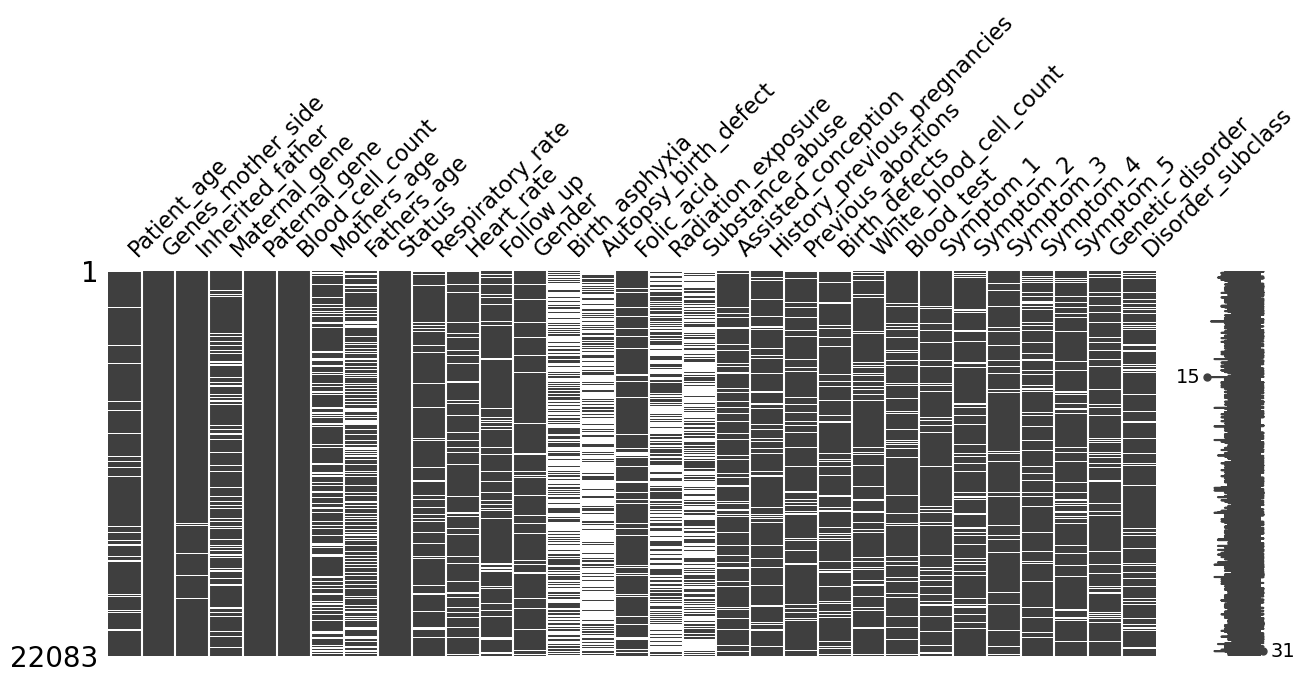

In [20]:
import missingno as msno

msno.matrix(genetic_df,figsize=(15,5))
plt.tight_layout()
plt.show()

In [21]:
genetic_df.shape

(22083, 31)

In [22]:
def drop_attributes_with_missingness(df, threshold=20):
    # Calculate the percentage of missing values for each column
    missing_counts = df.isnull().sum()
    missing_percentage = (df.isnull().sum() / len(df)) * 100
    print("Percentage of missing values in each column:")
    print(missing_percentage)
    

    # Find columns with missing values exceeding the threshold
    columns_to_drop = missing_percentage[missing_percentage > threshold].index

    # If no columns need to be dropped, return a message
    if columns_to_drop.empty:
        return "No attribute contains {}% missingness".format(threshold)

    # Otherwise, drop the identified columns
    genetic_df_dropped = df.drop(columns=columns_to_drop)
    return genetic_df_dropped


In [23]:
# Drop columns with missingness exceeding 20%
genetic_df_dropped = drop_attributes_with_missingness(genetic_df, threshold=20)

genetic_df_dropped.shape

Percentage of missing values in each column:
Patient_age                      6.461984
Genes_mother_side                0.000000
Inherited_father                 1.385681
Maternal_gene                   12.724720
Paternal_gene                    0.000000
Blood_cell_count                 0.000000
Mothers_age                     27.333243
Fathers_age                     27.106824
Status                           0.000000
Respiratory_rate                 9.731468
Heart_rate                       9.568446
Follow_up                        9.808450
Gender                           9.840149
Birth_asphyxia                  54.942716
Autopsy_birth_defect            70.076529
Folic_acid                       9.586560
Radiation_exposure              54.784223
Substance_abuse                 54.680071
Assisted_conception              9.609202
History_previous_pregnancies     9.835620
Previous_abortions               9.790336
Birth_defects                    9.754109
White_blood_cell_count         

(22083, 25)

Birth_asphyxia, Autopsy_birth_defect, Radiation_exposure and Substance_abuse columns have more than 20% missginess, it is reasonable to drop them

In [24]:
genetic_df_dropped.describe()

,Patient_age,Blood_cell_count,Previous_abortions,White_blood_cell_count,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5
count,20656.000000,22083.000000,19921.000000,19935.000000,19928.000000,19861.000000,19982.000000,19970.000000,19930.000000
mean,6.974148,4.898871,2.003062,7.486224,0.592483,0.551886,0.536233,0.497747,0.461917
std,4.319475,0.199663,1.411919,2.653393,0.491385,0.497313,0.498698,0.500007,0.498560
min,0.000000,4.092727,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,4.763109,1.000000,5.424703,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,4.899399,2.000000,7.477132,1.000000,1.000000,1.000000,0.000000,0.000000
75%,11.000000,5.033830,3.000000,9.526152,1.000000,1.000000,1.000000,1.000000,1.000000
max,14.000000,5.609829,4.000000,12.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## EDA


Attribute: Patient_age
Kurtosis: -1.2155976740982202
Skewness: 0.009507414389619285


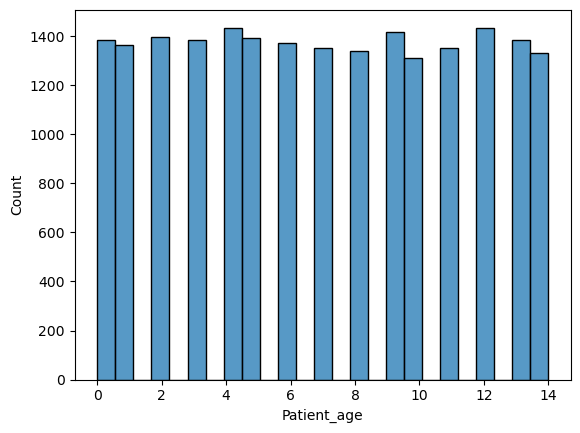

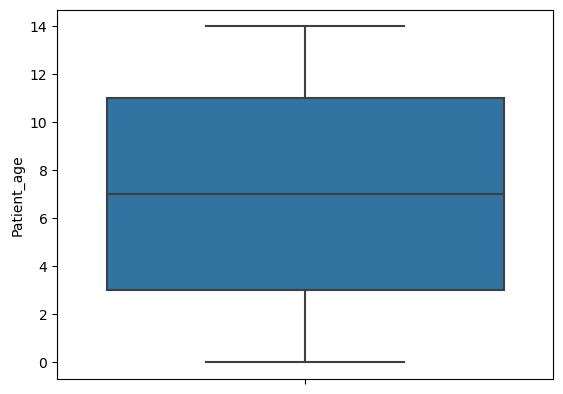


Attribute: Blood_cell_count
Kurtosis: -0.06282141886408121
Skewness: 0.010023413875847511


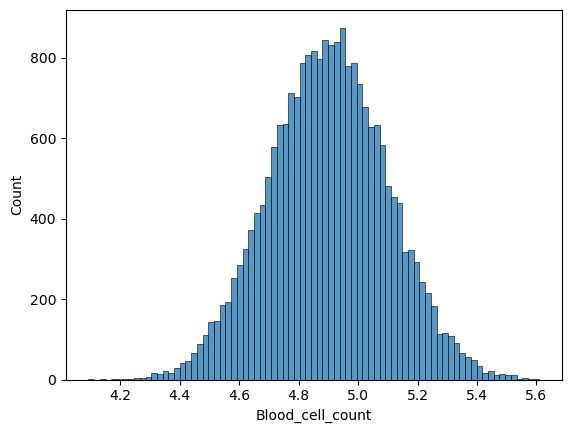

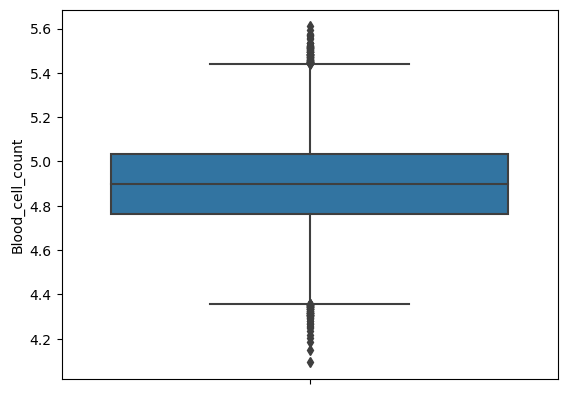


Attribute: Previous_abortions
Kurtosis: -1.2903552351093646
Skewness: -0.0010309052920366372


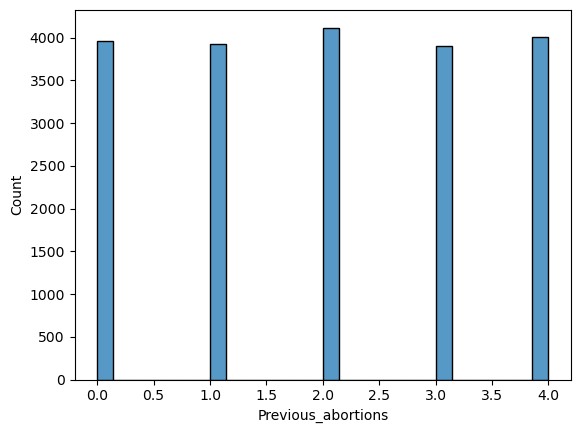

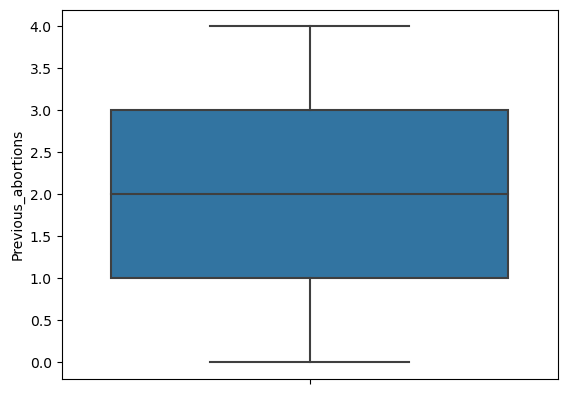


Attribute: White_blood_cell_count
Kurtosis: -0.9745044670063536
Skewness: 0.006638939182433682


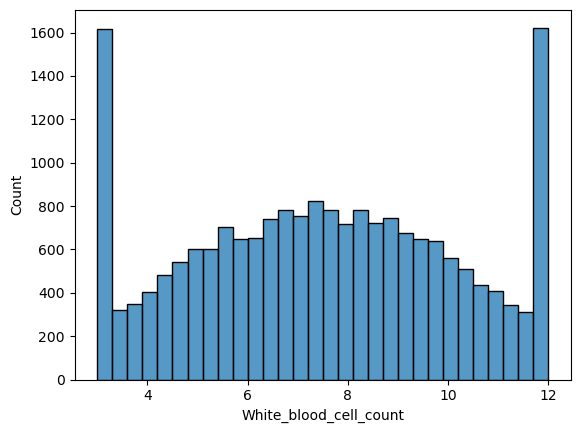

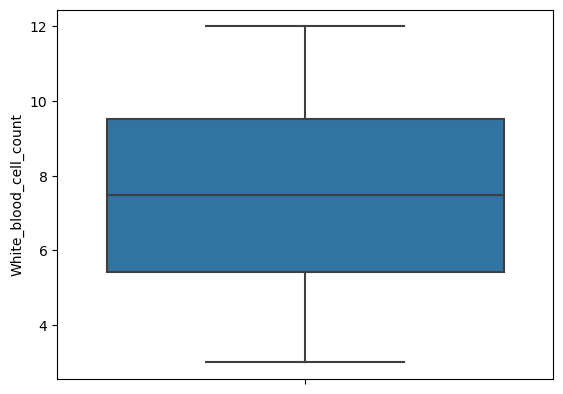


Attribute: Symptom_1
Kurtosis: -1.8584678898232179
Skewness: -0.37645536057455387


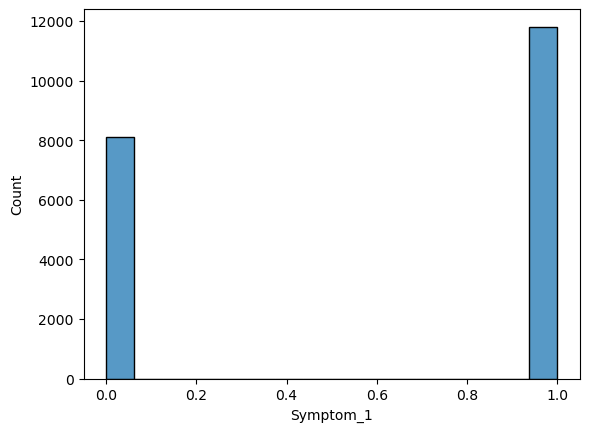

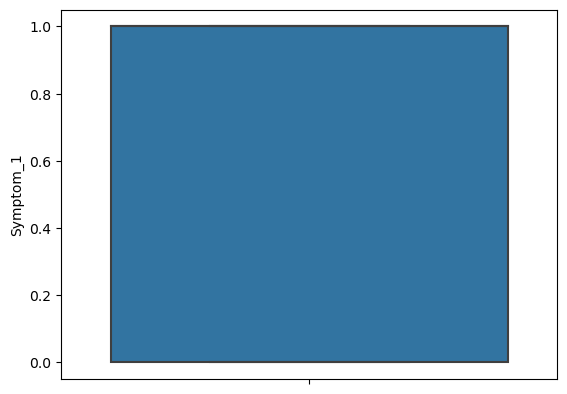


Attribute: Symptom_2
Kurtosis: -1.9566477217950093
Skewness: -0.20868474430717746


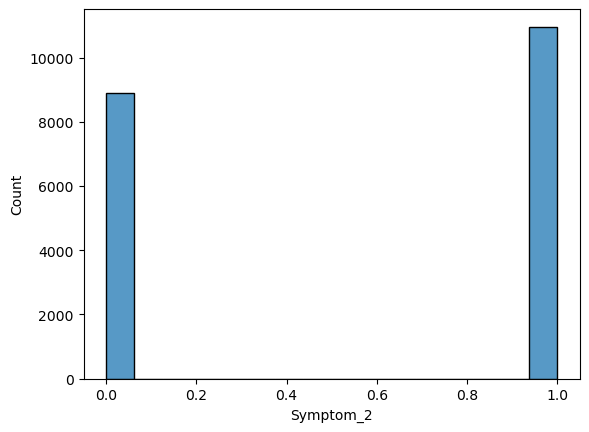

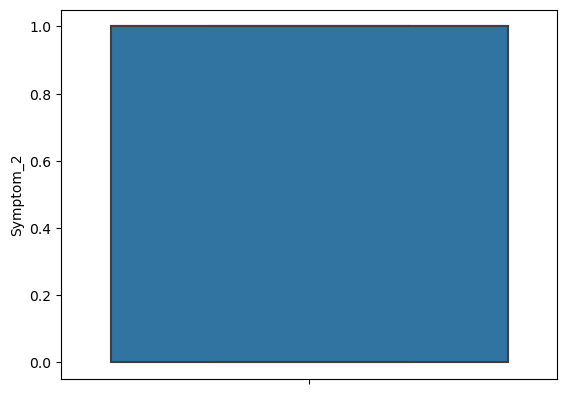


Attribute: Symptom_3
Kurtosis: -1.9790792108933086
Skewness: -0.14532338189320243


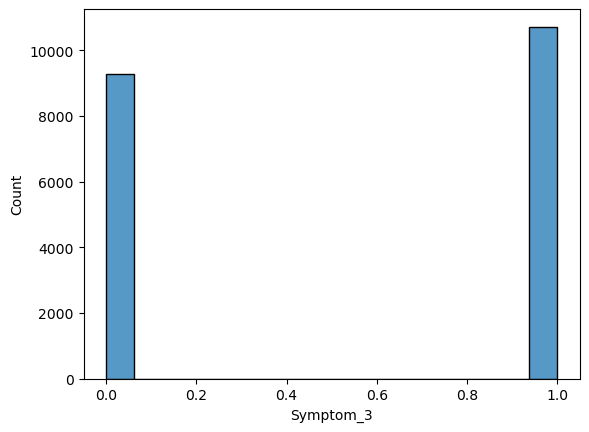

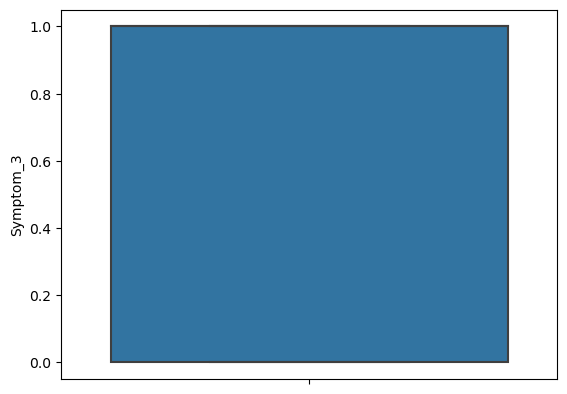


Attribute: Symptom_4
Kurtosis: -2.0001190650019125
Skewness: 0.009014288919538649


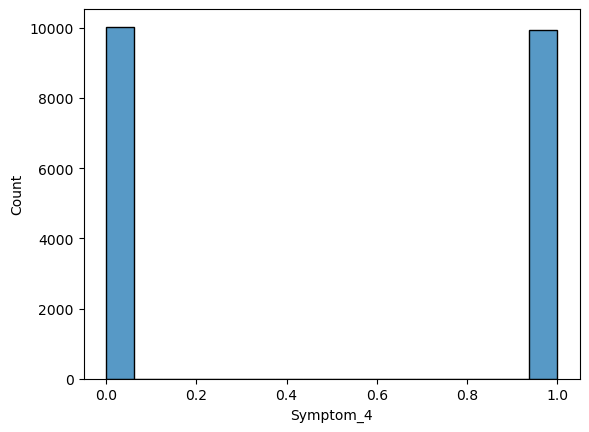

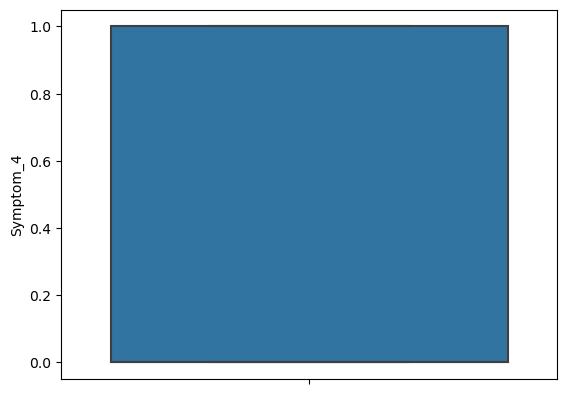


Attribute: Symptom_5
Kurtosis: -1.9768540743112504
Skewness: 0.15278846650559688


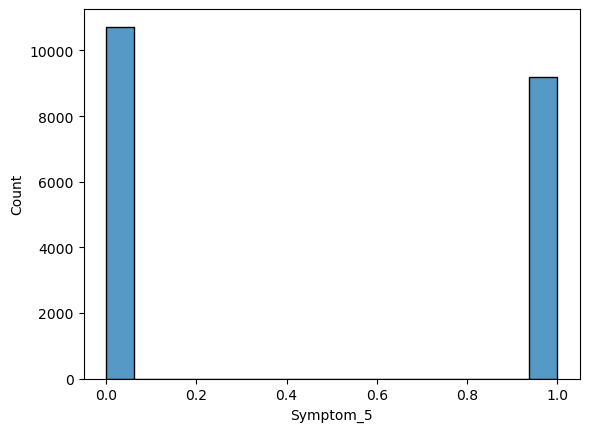

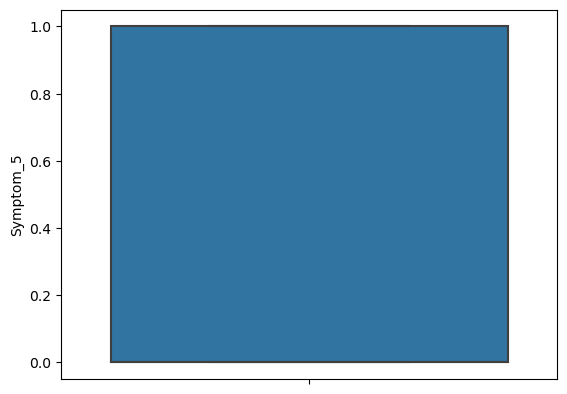

In [25]:
# List to store numeric column names
numeric_columns = []

# Iterate through columns and identify numeric ones
for attr in genetic_df_dropped.columns:
    if np.issubdtype(genetic_df_dropped[attr].dtype, np.number):
        numeric_columns.append(attr)

# Calculate kurtosis and skewness for numeric columns
for attr in numeric_columns:
    print('\nAttribute:', attr)
    print(f'Kurtosis: {genetic_df_dropped[attr].kurt()}')
    print(f'Skewness: {genetic_df_dropped[attr].skew()}')
    sns.histplot(data=genetic_df_dropped, x=genetic_df_dropped[attr])
    plt.show()
    sns.boxplot(data=genetic_df_dropped, y=genetic_df_dropped[attr])
    plt.show()

## Percentage of genetic disorder classes and cases of specific disorder subclasses

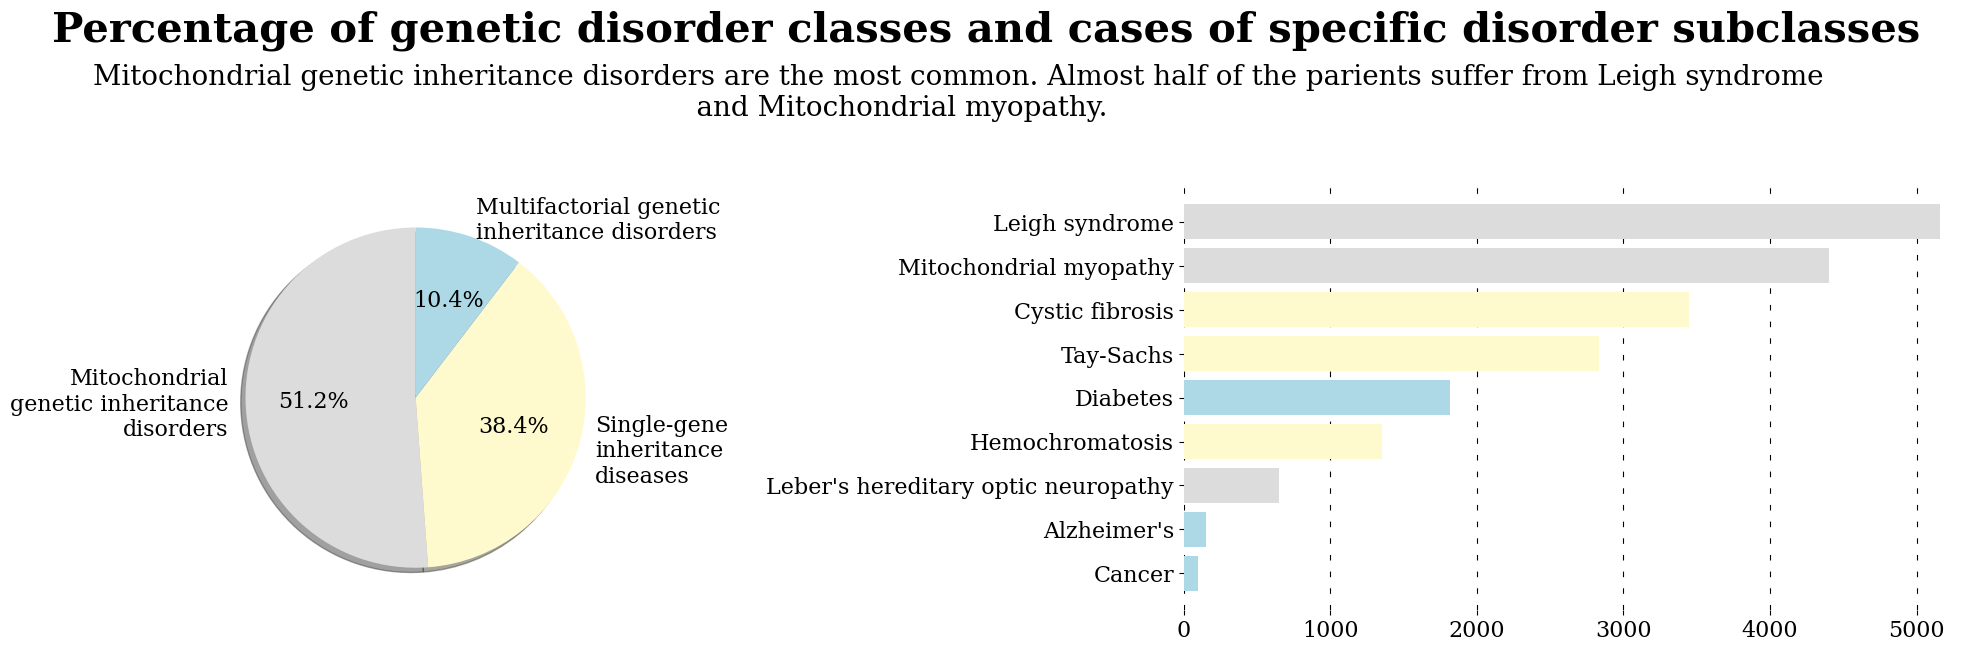

In [26]:
genetic_disorder=genetic_df_dropped['Genetic_disorder'].value_counts().reset_index()
genetic_disorder.columns=['disorder','count']
subclass=genetic_df['Disorder_subclass'].value_counts().reset_index()
subclass.columns=['subclass','count']


plt.rcParams['font.family'] = 'serif'
fig=plt.figure(figsize=(20,40),facecolor='white')
gs=fig.add_gridspec(8,2)

ax0=fig.add_subplot(gs[0,0])
ax1=fig.add_subplot(gs[0,1])

colormap1=['Gainsboro','LemonChiffon','LightBlue']
colormap2=['Gainsboro','Gainsboro','LemonChiffon','LemonChiffon','LightBlue','LemonChiffon','Gainsboro','LightBlue','LightBlue']

fig.suptitle('Percentage of genetic disorder classes and cases of specific disorder subclasses \n\n\n\n', fontsize=30, fontweight='bold', ha='center')
fig.text(0.05,0.93,'Mitochondrial genetic inheritance disorders are the most common. Almost half of the parients suffer from Leigh syndrome\n\
                                                                    and Mitochondrial myopathy.\n\n\n',fontsize=20, fontfamily='serif')
ax0.pie(genetic_disorder['count'],labels=['Mitochondrial\ngenetic inheritance\ndisorders','Single-gene\ninheritance\ndiseases','Multifactorial genetic\ninheritance disorders'], autopct='%1.1f%%',
        shadow=True, startangle=90,colors=colormap1, textprops={'fontsize': 16})

ax1.barh(subclass['subclass'], subclass['count'],color=colormap2, zorder=2)
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(axis='x', labelsize=16)
ax1.invert_yaxis()
ax1.grid(color='black', linestyle=':', axis='x', zorder=1,  dashes=(5,10))
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
plt.tight_layout()
plt.savefig('image1.png')
plt.show()

## Patients' status according to disorder subclass

C:\Users\disle\AppData\Local\Temp\ipykernel_1352\2934417449.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


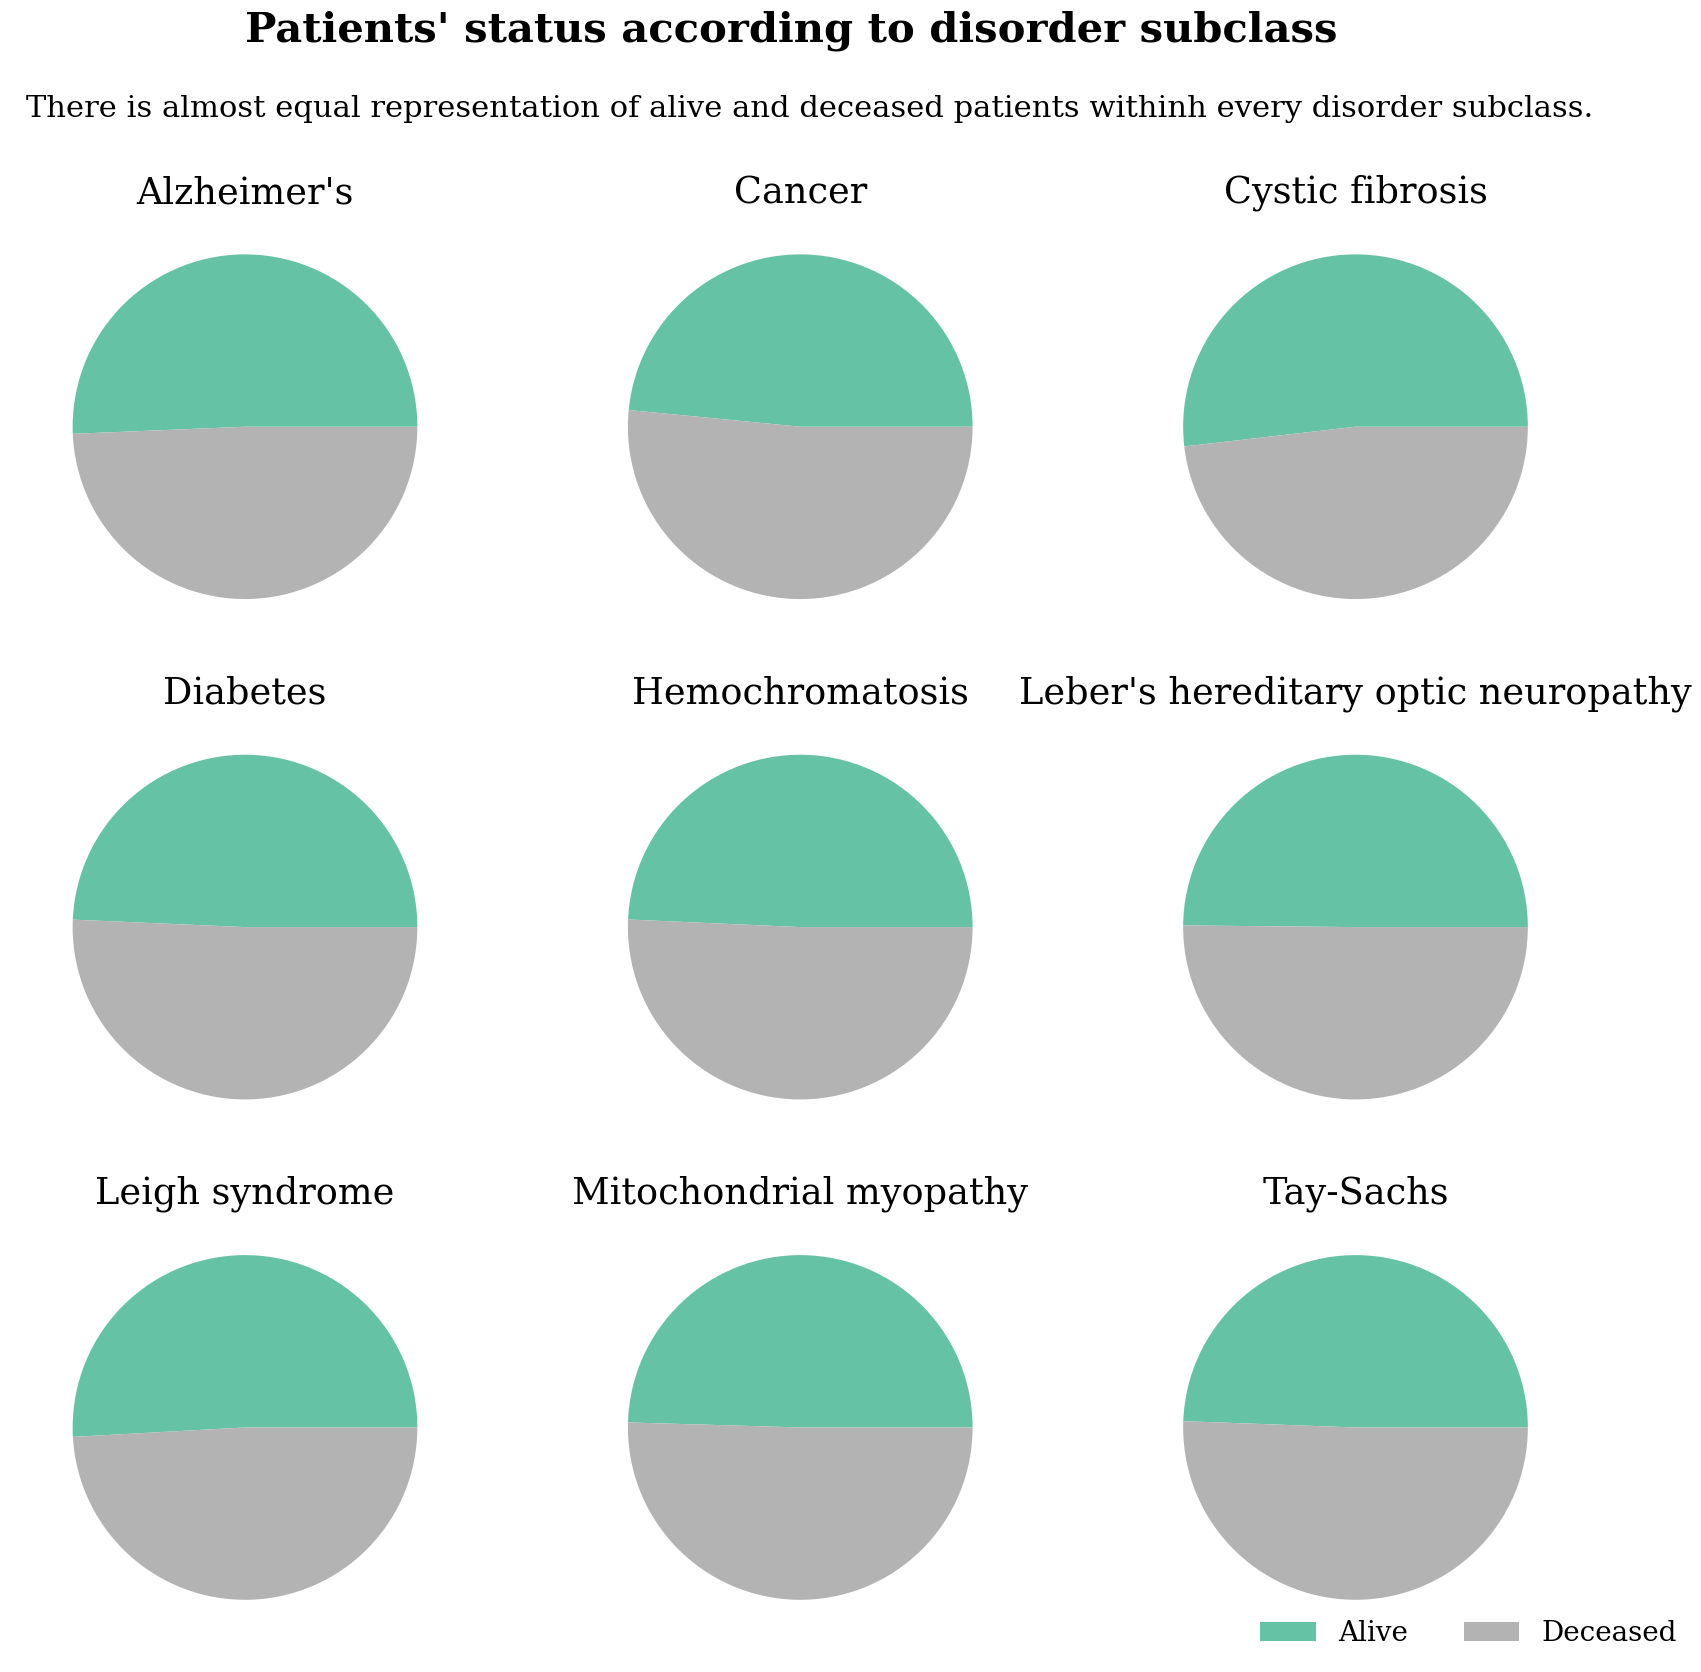

In [27]:
fig,axes = plt.subplots(nrows=3,ncols=3, figsize=(17,17))
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 22


genetic_df_dropped.loc[genetic_df_dropped['Disorder_subclass']=="Alzheimer's"]['Status'].value_counts().sort_index().plot.pie(ax=axes[0,0],title="Alzheimer's",rot=0,fontsize=20, ylabel=' ', colormap = 'Set2', labeldistance=None)
genetic_df_dropped.loc[genetic_df_dropped['Disorder_subclass']=="Cancer"]['Status'].value_counts().sort_index().plot.pie(ax=axes[0,1], title="Cancer",rot=0,fontsize=20, ylabel=' ', colormap = 'Set2', labeldistance=None)
genetic_df_dropped.loc[genetic_df_dropped['Disorder_subclass']=="Cystic fibrosis"]['Status'].value_counts().sort_index().plot.pie(ax=axes[0,2], title="Cystic fibrosis",rot=0,fontsize=20, colormap = 'Set2', ylabel=' ', labeldistance=None)
genetic_df_dropped.loc[genetic_df_dropped['Disorder_subclass']=="Diabetes"]['Status'].value_counts().sort_index().plot.pie(ax=axes[1,0], title="Diabetes",rot=0,fontsize=20, colormap = 'Set2', ylabel=' ', labeldistance=None)
genetic_df_dropped.loc[genetic_df_dropped['Disorder_subclass']=="Hemochromatosis"]['Status'].value_counts().sort_index().plot.pie(ax=axes[1,1], title="Hemochromatosis",rot=0,fontsize=20, colormap = 'Set2', ylabel=' ', labeldistance=None)
genetic_df_dropped.loc[genetic_df_dropped['Disorder_subclass']=="Leber's hereditary optic neuropathy"]['Status'].value_counts().sort_index().plot.pie(ax=axes[1,2],title="Leber's hereditary optic neuropathy",rot=0,fontsize=20, colormap = 'Set2', ylabel=' ', labeldistance=None)
genetic_df_dropped.loc[genetic_df_dropped['Disorder_subclass']=="Leigh syndrome"]['Status'].value_counts().sort_index().plot.pie(ax=axes[2,0],title="Leigh syndrome",rot=0,fontsize=20, colormap = 'Set2', ylabel=' ', labeldistance=None)
genetic_df_dropped.loc[genetic_df_dropped['Disorder_subclass']=="Mitochondrial myopathy"]['Status'].value_counts().sort_index().plot.pie(ax=axes[2,1],title="Mitochondrial myopathy",rot=0,fontsize=20, colormap = 'Set2', ylabel=' ', labeldistance=None)
genetic_df_dropped.loc[genetic_df_dropped['Disorder_subclass']=="Tay-Sachs"]['Status'].value_counts().sort_index().plot.pie(ax=axes[2,2],title="Tay-Sachs",rot=0,fontsize=20, colormap = 'Set2', ylabel=' ', labeldistance=None)
fig.suptitle("Patients' status according to disorder subclass\n\n", fontsize=30, fontweight='bold', ha='center') 
fig.tight_layout()
fig.text(0.05,0.86,'There is almost equal representation of alive and deceased patients withinh every disorder subclass.\n\n\n',fontsize=22, fontfamily='serif')
fig.legend(['Alive', 'Deceased'], loc='lower right', frameon=False, fontsize=20, ncol=2)


fig.show()

## Occurence of specific symptoms according to disorder subclass

In [28]:
hemo = (genetic_df_dropped[genetic_df_dropped['Disorder_subclass']=="Hemochromatosis"][['Symptom_1','Symptom_2','Symptom_3','Symptom_4','Symptom_5']]==1).sum().to_frame().rename(columns={0:'Hemochromatosis'})
leber = (genetic_df_dropped[genetic_df_dropped['Disorder_subclass']=="Leber's hereditary optic neuropathy"][['Symptom_1','Symptom_2','Symptom_3','Symptom_4','Symptom_5']]==1).sum().to_frame().rename(columns={0 : "Leber's hereditary optic neuropathy"})
diabetes = (genetic_df_dropped[genetic_df_dropped['Disorder_subclass']=='Diabetes'][['Symptom_1','Symptom_2','Symptom_3','Symptom_4','Symptom_5']]==1).sum().to_frame().rename(columns={0 : 'Diabetes'})
leigh = (genetic_df_dropped[genetic_df_dropped['Disorder_subclass']=='Leigh syndrome'][['Symptom_1','Symptom_2','Symptom_3','Symptom_4','Symptom_5']]==1).sum().to_frame().rename(columns={0 : 'Leigh syndrome'})
cancer = (genetic_df_dropped[genetic_df_dropped['Disorder_subclass']=='Cancer'][['Symptom_1','Symptom_2','Symptom_3','Symptom_4','Symptom_5']]==1).sum().to_frame().rename(columns={0 : 'Cancer'})
cystic = (genetic_df_dropped[genetic_df_dropped['Disorder_subclass']=='Cystic fibrosis'][['Symptom_1','Symptom_2','Symptom_3','Symptom_4','Symptom_5']]==1).sum().to_frame().rename(columns={0 : 'Cystic fibrosis'})
tay = (genetic_df_dropped[genetic_df_dropped['Disorder_subclass']=='Tay-Sachs'][['Symptom_1','Symptom_2','Symptom_3','Symptom_4','Symptom_5']]==1).sum().to_frame().rename(columns={0 : 'Tay-Sachs'})
mitomyo = (genetic_df_dropped[genetic_df_dropped['Disorder_subclass']=='Mitochondrial myopathy'][['Symptom_1','Symptom_2','Symptom_3','Symptom_4','Symptom_5']]==1).sum().to_frame().rename(columns={0 : 'Mitochondrial myopathy'})
alzh = (genetic_df_dropped[genetic_df_dropped['Disorder_subclass']=="Alzheimer's"][['Symptom_1','Symptom_2','Symptom_3','Symptom_4','Symptom_5']]==1).sum().to_frame().rename(columns={0 : "Alzheimer's"})

symptom_wise = pd.concat([hemo,leber,diabetes,leigh,cancer,cystic,tay,mitomyo,alzh], axis=1).transpose()
symptom_wise

,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5
Hemochromatosis,489,366,295,205,135
Leber's hereditary optic neuropathy,500,508,530,543,549
Diabetes,1266,1275,1366,1324,1372
Leigh syndrome,2737,2591,2543,2288,2107
Cancer,19,8,8,2,1
Cystic fibrosis,2237,2195,2252,2244,2246
Tay-Sachs,1209,968,917,706,511
Mitochondrial myopathy,2138,1871,1698,1585,1284
Alzheimer's,125,128,139,137,138


In [29]:
symptom_wise.corr()

,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5
Symptom_1,1.000000,0.994992,0.984276,0.968344,0.927895
Symptom_2,0.994992,1.000000,0.996550,0.987531,0.959315
Symptom_3,0.984276,0.996550,1.000000,0.995433,0.977500
Symptom_4,0.968344,0.987531,0.995433,1.000000,0.991175
Symptom_5,0.927895,0.959315,0.977500,0.991175,1.000000


Text(-0.8, 3200, 'All of the symptoms appear in all of the disorders subclasses.Generally symptoms 1,2 and 3\n                                 are more common than symptoms 4 and 5.\n')

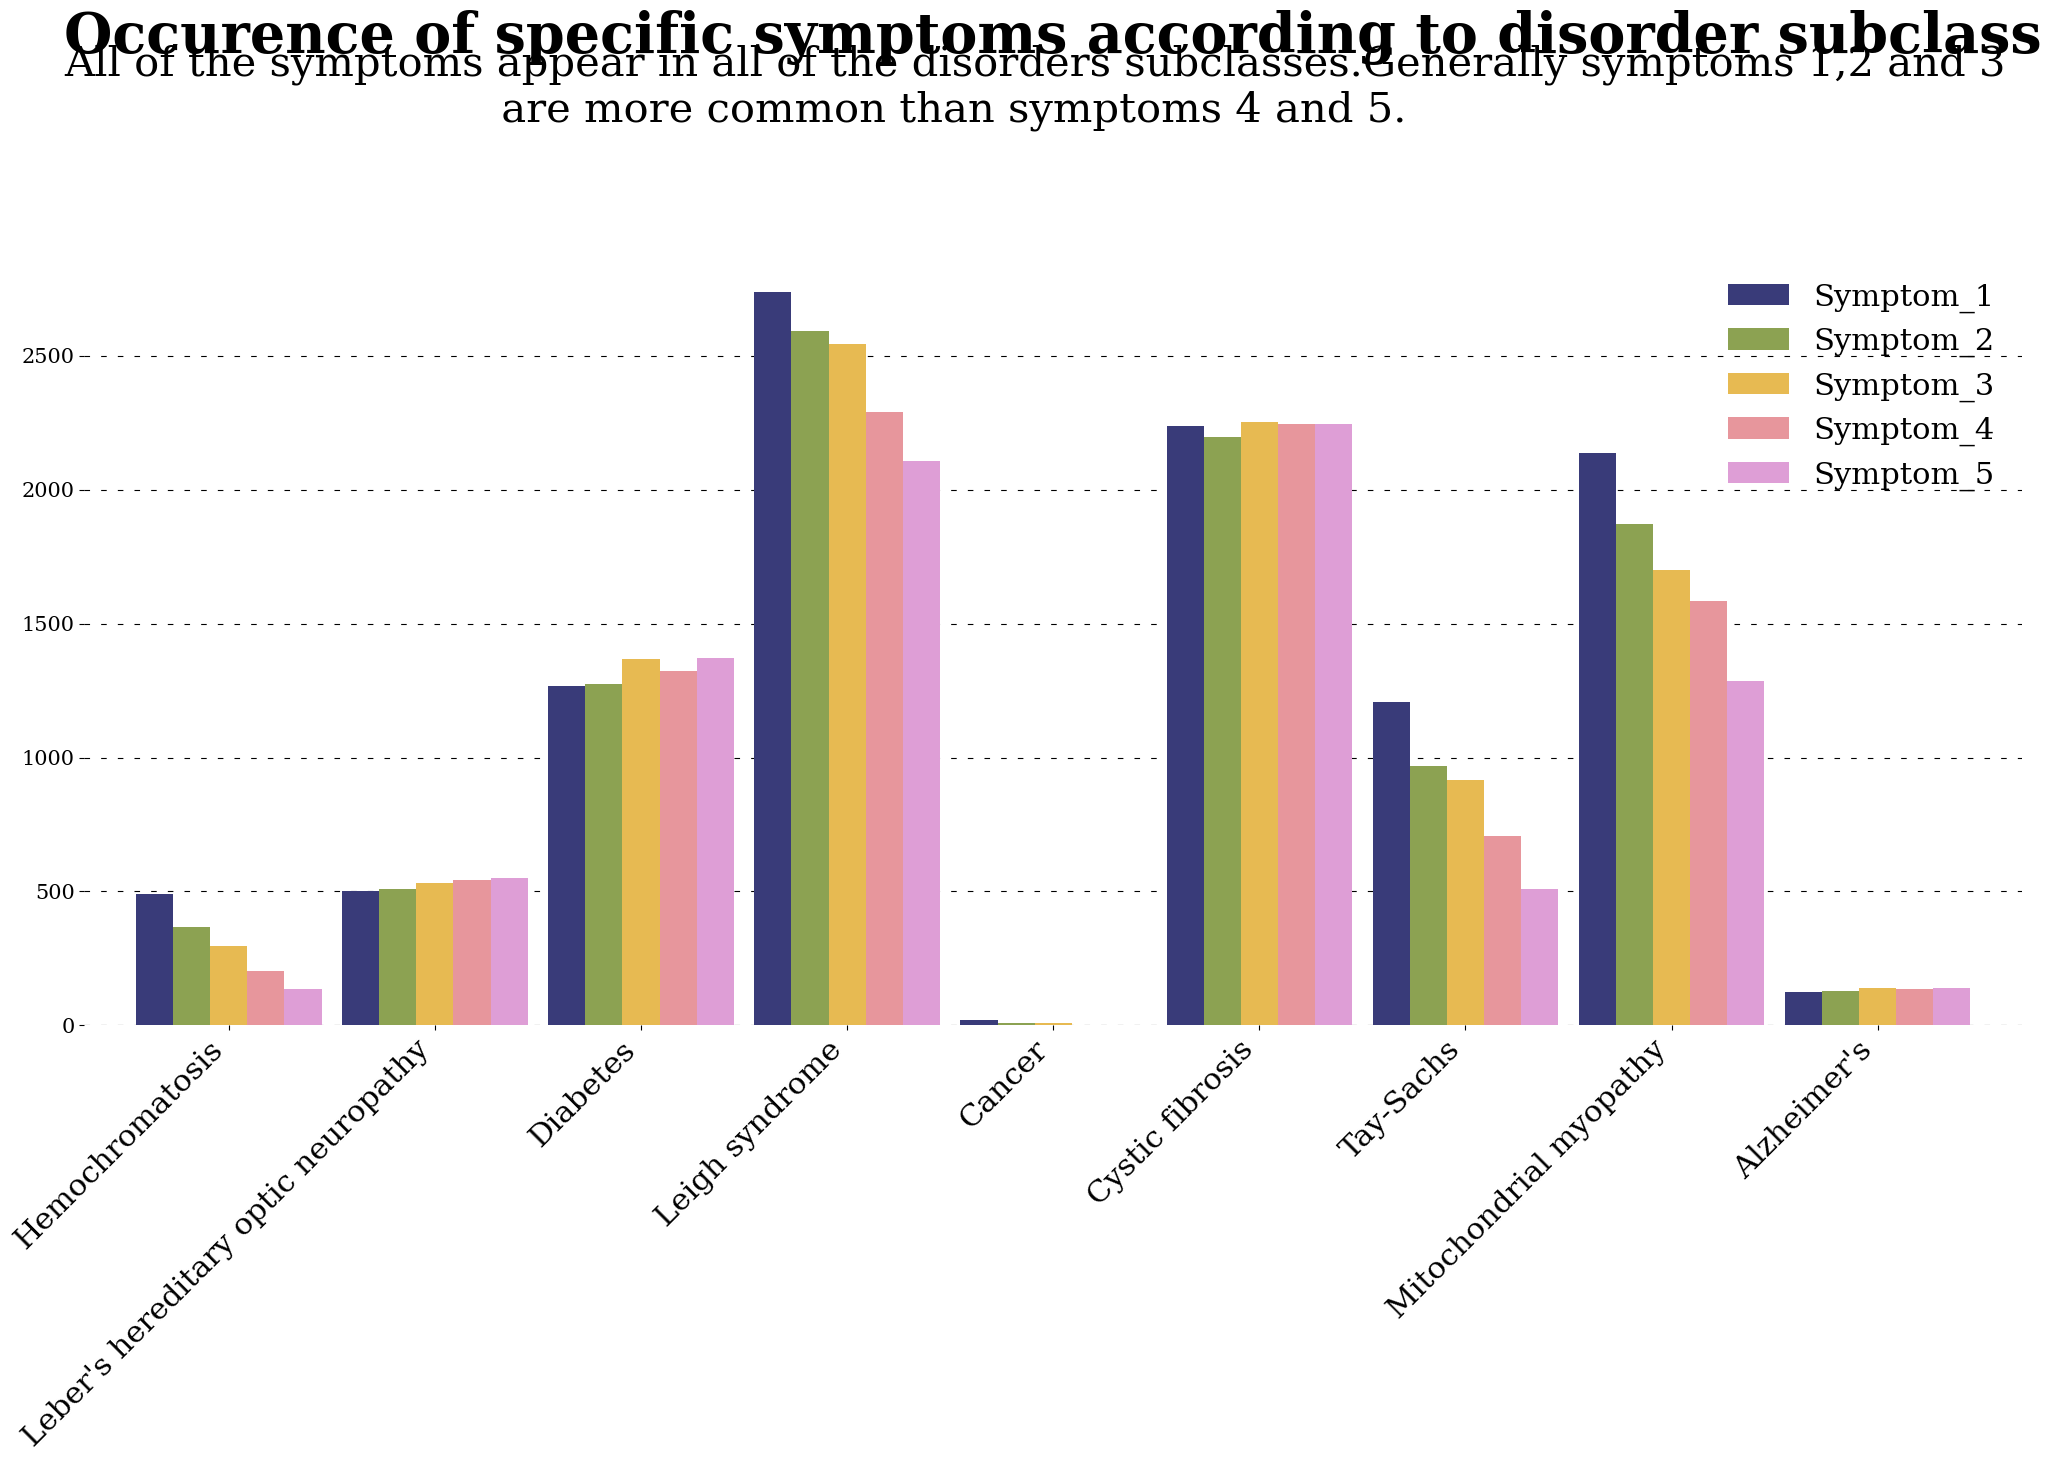

In [30]:
plt.rcParams['figure.frameon']= False
symptom_wise.plot.bar(figsize=(25,10),colormap = 'tab20b', fontsize=15,width=0.9,zorder=2)
plt.title('Occurence of specific symptoms according to disorder subclass\n\n\n', fontsize=40,fontweight='bold',ha='center')
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light',
    fontsize=22,
)
plt.grid(color='black', linestyle=':', axis='y', zorder=1,  dashes=(5,10))
plt.box(False)
plt.legend(loc='best',frameon=False)    
plt.text(-0.8,3200,'All of the symptoms appear in all of the disorders subclasses.Generally symptoms 1,2 and 3\n\
                                 are more common than symptoms 4 and 5.\n',fontsize=30, fontfamily='serif')
        

Presence of defective maternal and parental genes according to disorder subclass

C:\Users\disle\AppData\Local\Temp\ipykernel_1352\3964550429.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


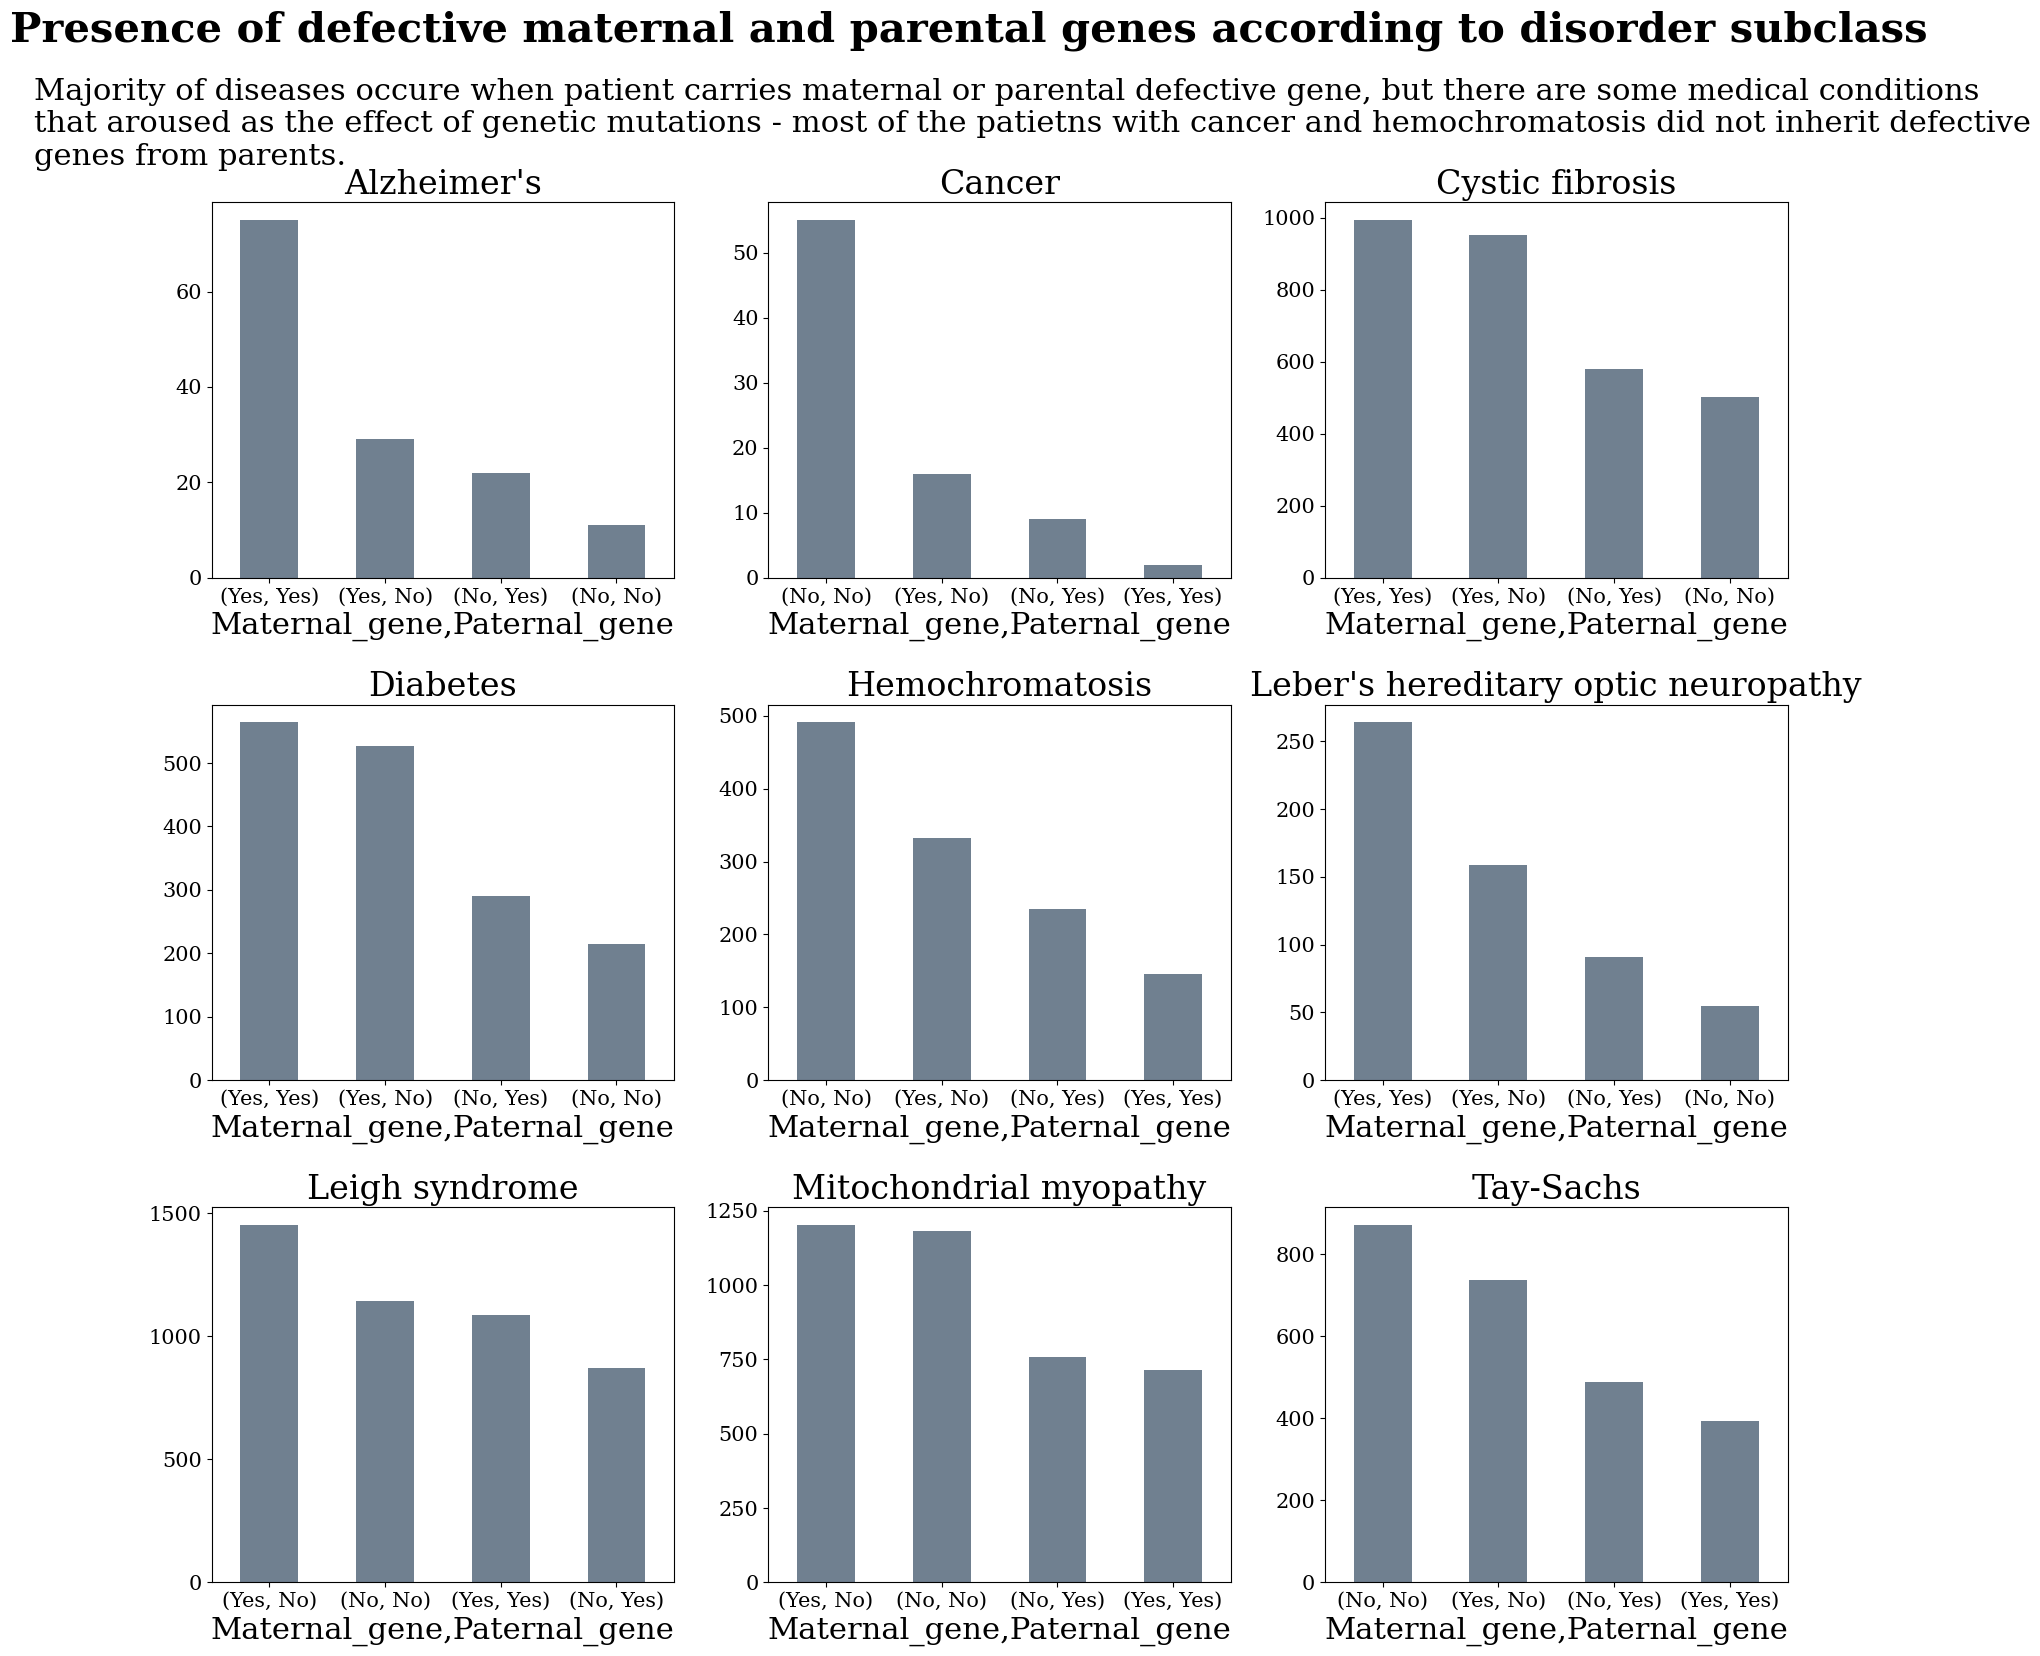

In [31]:
fig,axes = plt.subplots(nrows=3,ncols=3, figsize=(17,17))
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 20

genetic_df_dropped[genetic_df_dropped['Disorder_subclass']=="Alzheimer's"][['Maternal_gene','Paternal_gene']].value_counts().plot.bar(ax=axes[0,0],title="Alzheimer's",rot=0,fontsize=15, color='slategray')
genetic_df_dropped[genetic_df_dropped['Disorder_subclass']=="Cancer"][['Maternal_gene','Paternal_gene']].value_counts().plot.bar(ax=axes[0,1], title="Cancer",rot=0,fontsize=15, color='slategray')
genetic_df_dropped[genetic_df_dropped['Disorder_subclass']=="Cystic fibrosis"][['Maternal_gene','Paternal_gene']].value_counts().plot.bar(ax=axes[0,2], title="Cystic fibrosis",rot=0,fontsize=15, color='slategray')
genetic_df_dropped[genetic_df_dropped['Disorder_subclass']=="Diabetes"][['Maternal_gene','Paternal_gene']].value_counts().plot.bar(ax=axes[1,0], title="Diabetes",rot=0,fontsize=15, color='slategray')
genetic_df_dropped[genetic_df_dropped['Disorder_subclass']=="Hemochromatosis"][['Maternal_gene','Paternal_gene']].value_counts().plot.bar(ax=axes[1,1], title="Hemochromatosis",rot=0,fontsize=15, color='slategray')
genetic_df_dropped[genetic_df_dropped['Disorder_subclass']=="Leber's hereditary optic neuropathy"][['Maternal_gene','Paternal_gene']].value_counts().plot.bar(ax=axes[1,2],title="Leber's hereditary optic neuropathy",rot=0,fontsize=15, color='slategray')
genetic_df_dropped[genetic_df_dropped['Disorder_subclass']=="Leigh syndrome"][['Maternal_gene','Paternal_gene']].value_counts().plot.bar(ax=axes[2,0],title="Leigh syndrome",rot=0,fontsize=15, color='slategray')
genetic_df_dropped[genetic_df_dropped['Disorder_subclass']=="Mitochondrial myopathy"][['Maternal_gene','Paternal_gene']].value_counts().plot.bar(ax=axes[2,1],title="Mitochondrial myopathy",rot=0,fontsize=15, color='slategray')
genetic_df_dropped[genetic_df_dropped['Disorder_subclass']=="Tay-Sachs"][['Maternal_gene','Paternal_gene']].value_counts().plot.bar(ax=axes[2,2],title="Tay-Sachs",rot=0,fontsize=15, color='slategray')
fig.suptitle('Presence of defective maternal and parental genes according to disorder subclass\n\n', fontsize=30, fontweight='bold', ha='center') 
fig.tight_layout()
fig.text(-0.05,0.87,'Majority of diseases occure when patient carries maternal or parental defective gene, but there are some medical conditions\n\
that aroused as the effect of genetic mutations - most of the patietns with cancer and hemochromatosis did not inherit defective\n\
genes from parents.\n',fontsize=22, fontfamily='serif')


fig.show()

## Correlations

To get full insight into correlations between features all categorical features need to be change for numerical features.

In [32]:
numeric_features = ['Patient_age','Blood_cell_count','Previous_abortions',
                    'White_blood_cell_count']

categorical_features =  ['Genes_mother_side','Inherited_father','Maternal_gene','Paternal_gene','Status','Respiratory_rate',
                         'Heart_rate','Follow_up','Gender','Folic_acid','Assisted_conception','History_previous_pregnancies',
                         'Birth_defects','Blood_test','Symptom_1', 'Symptom_2','Symptom_3', 'Symptom_4', 'Symptom_5']

target = ['Genetic_disorder','Disorder_subclass']


In [33]:
corr_df = genetic_df_dropped[numeric_features].corr()
corr_df

,Patient_age,Blood_cell_count,Previous_abortions,White_blood_cell_count
Patient_age,1.000000,0.010819,-0.007281,-0.008489
Blood_cell_count,0.010819,1.000000,-0.005995,-0.001037
Previous_abortions,-0.007281,-0.005995,1.000000,0.003807
White_blood_cell_count,-0.008489,-0.001037,0.003807,1.000000


<Axes: >

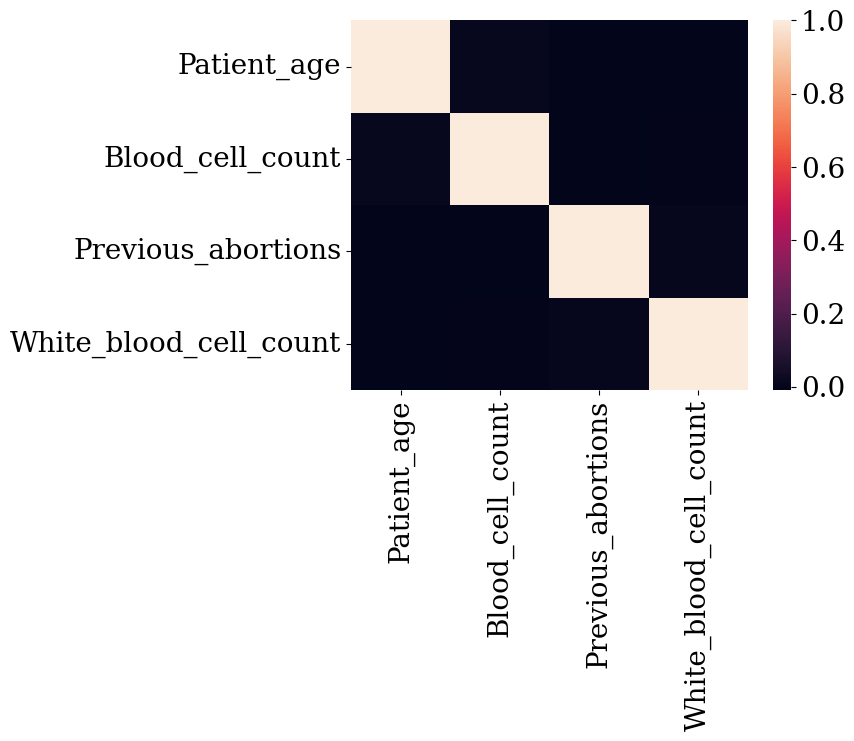

In [34]:
sns.heatmap(corr_df)

<P><b> Promising transformation includes normalizing,and imputing numerical attributes and encoding categorical attr

In [35]:
genetic_df_dropped.to_csv('data/genetic_df.csv')

## Interactive report

In [36]:
import sweetviz as sv

my_report = sv.analyze(genetic_df_dropped)
my_report.show_html("my_report.html")  # Save the report as "my_report.html"

                                             |                                             | [  0%]   00:00 ->…

Report my_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



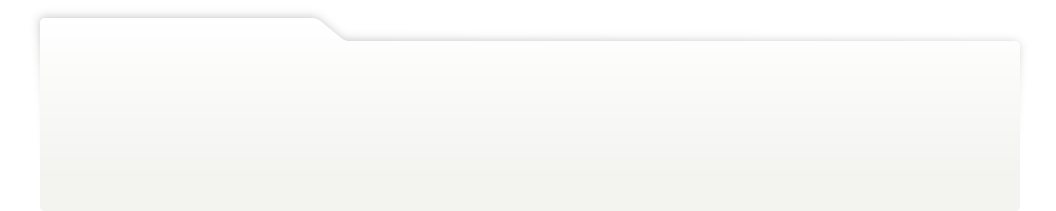
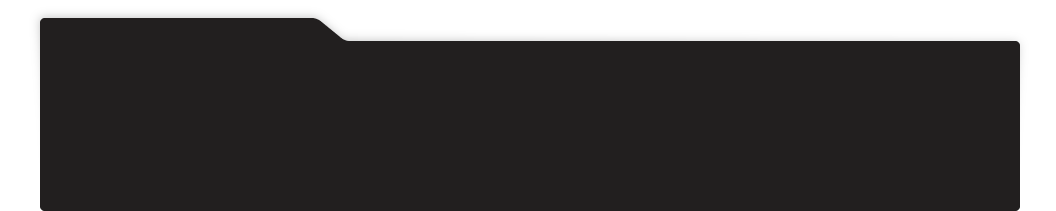
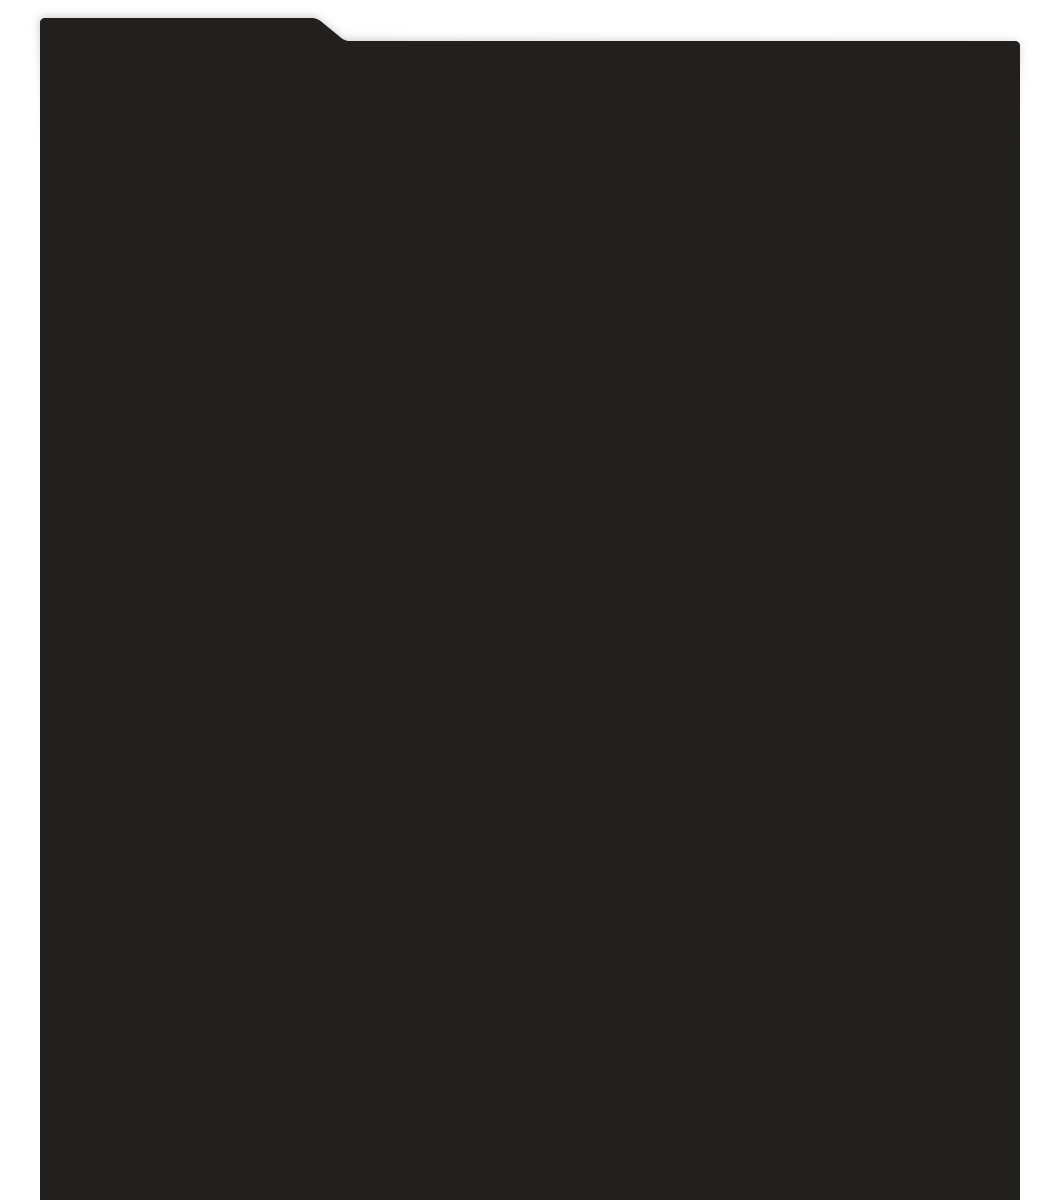
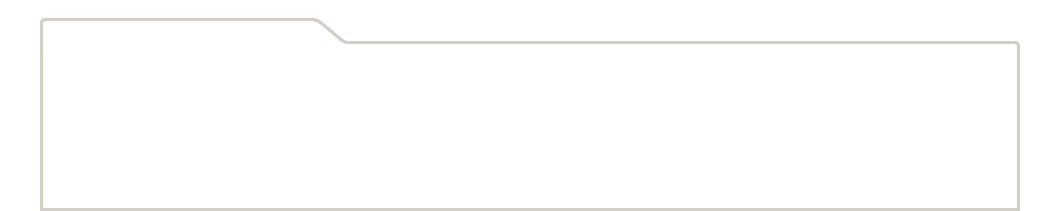
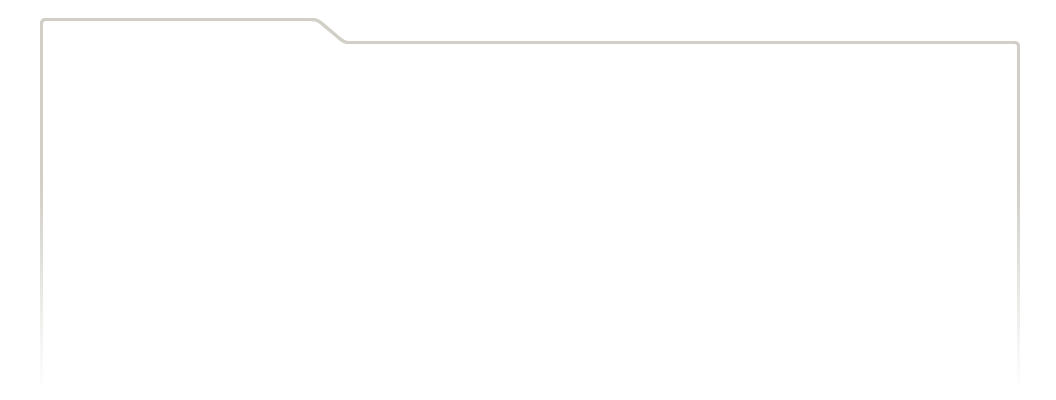
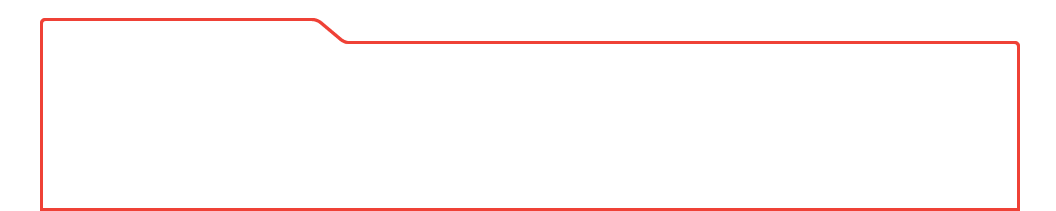
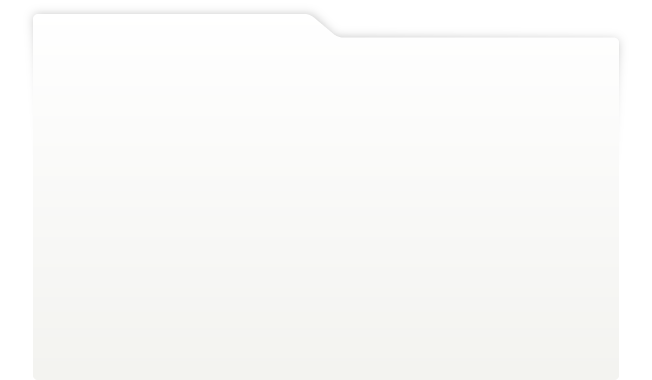
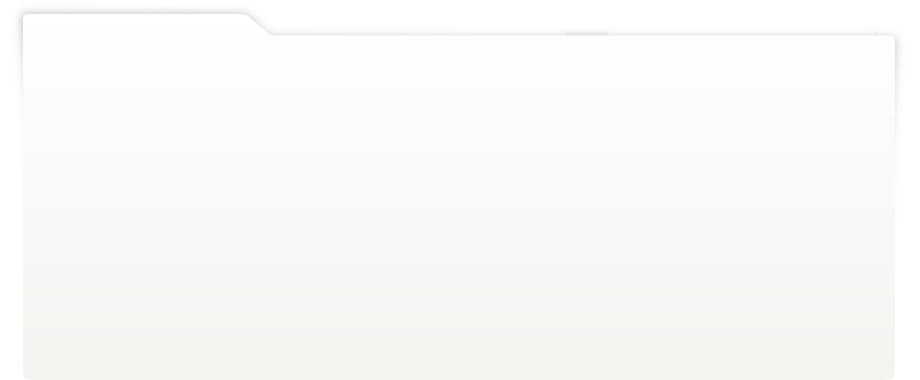
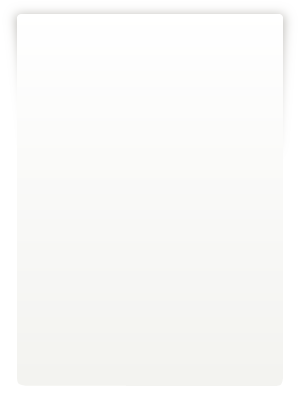
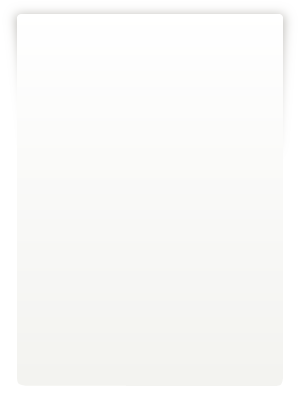
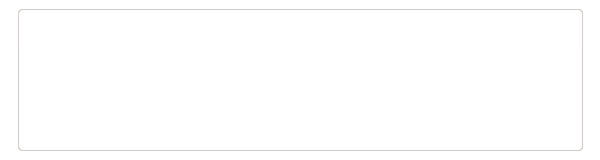
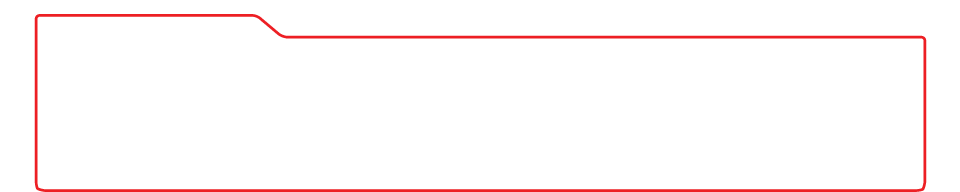
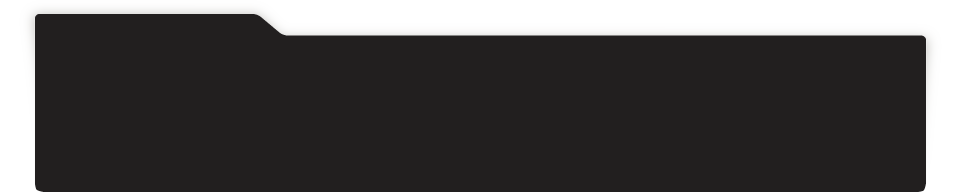
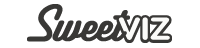
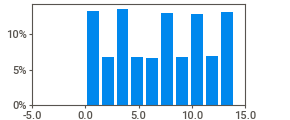
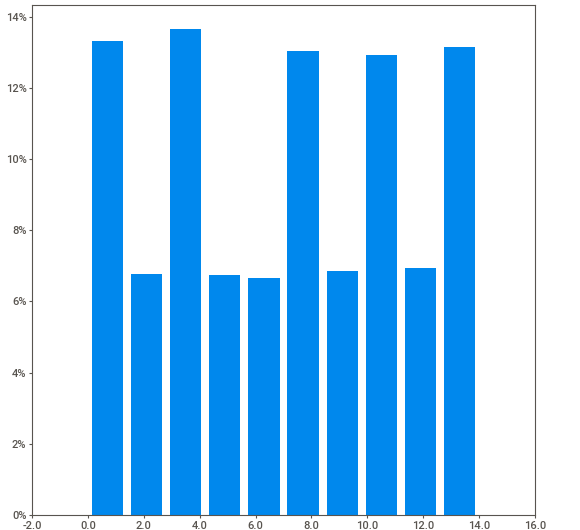
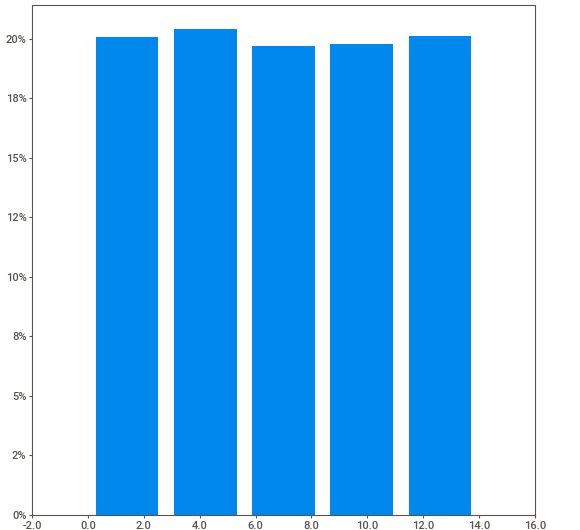
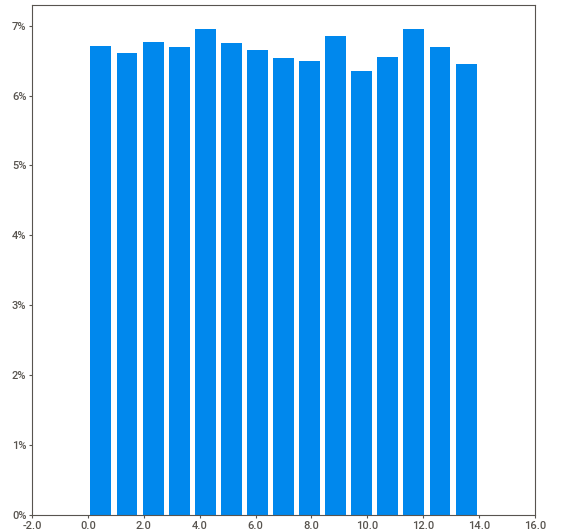
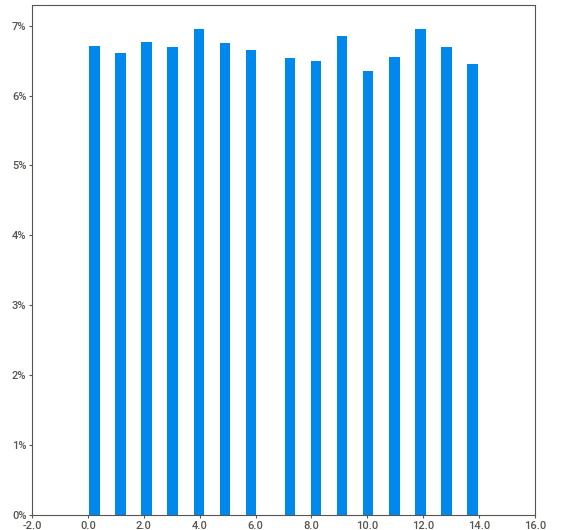
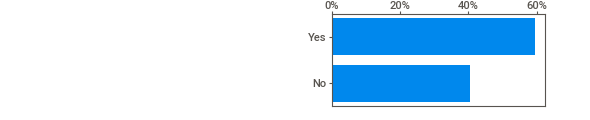
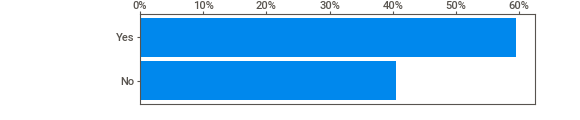
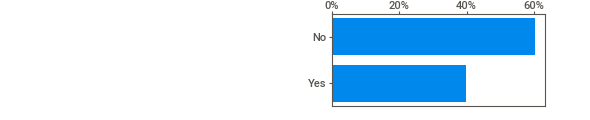
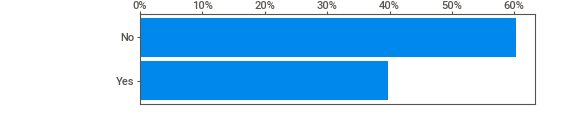
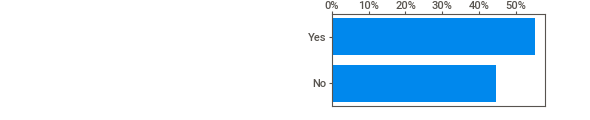
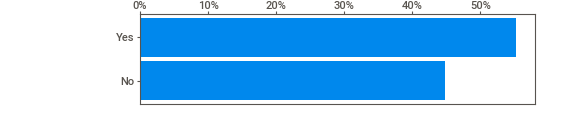
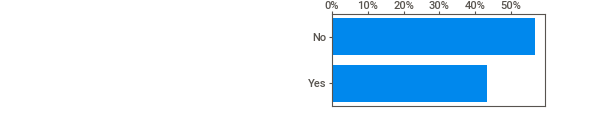
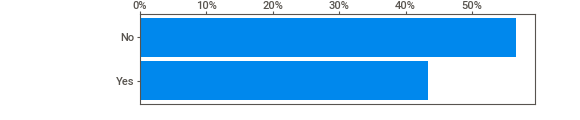
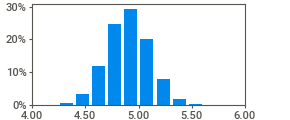
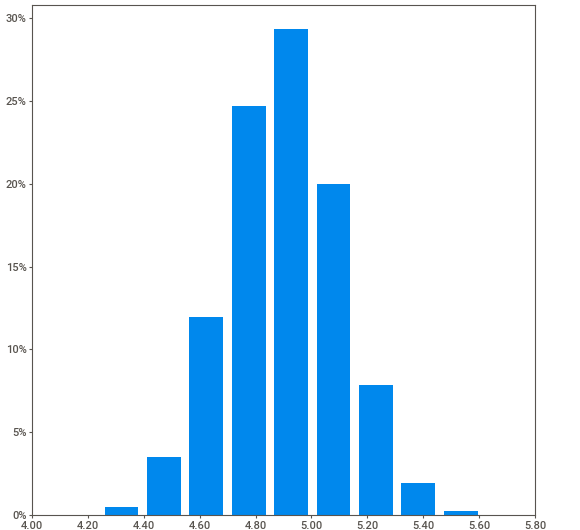
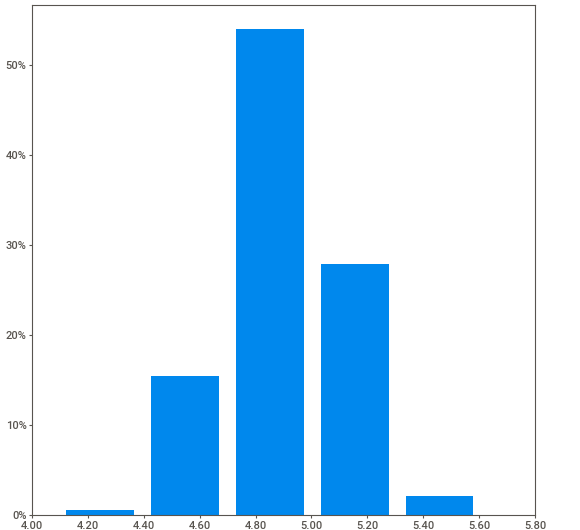
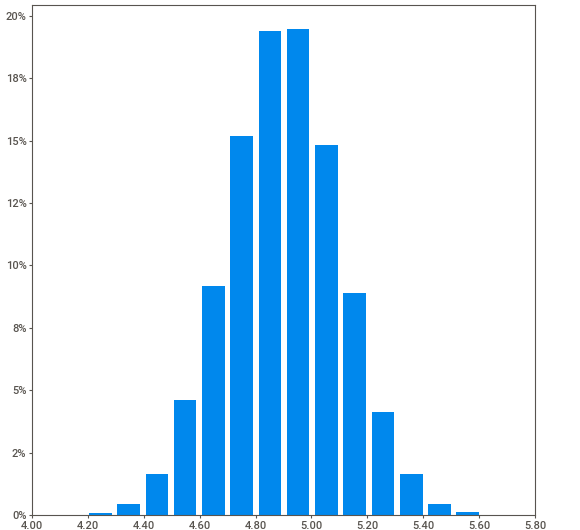
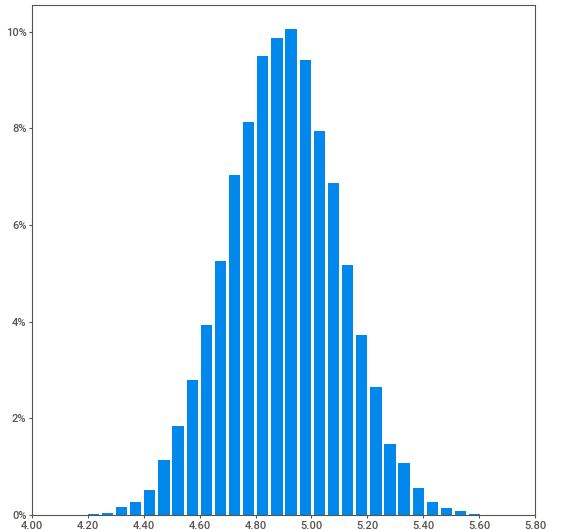
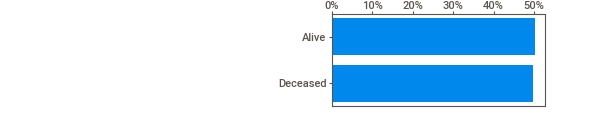
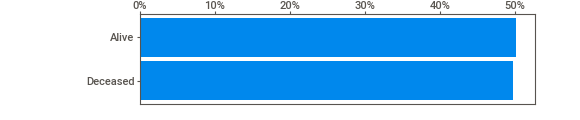
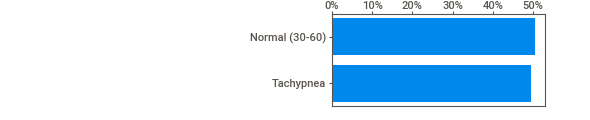
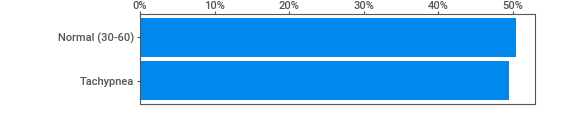
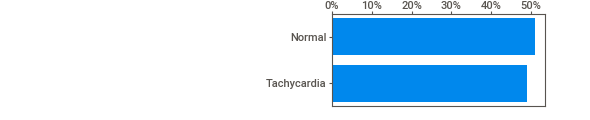
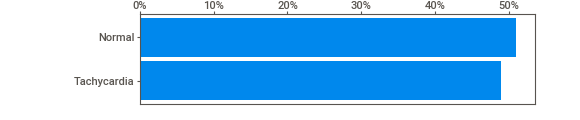
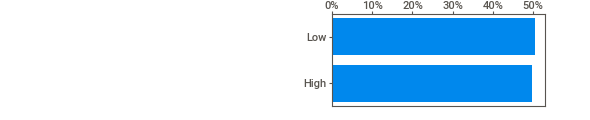
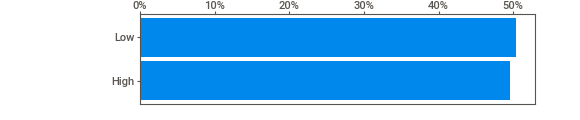
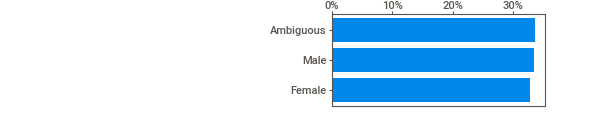
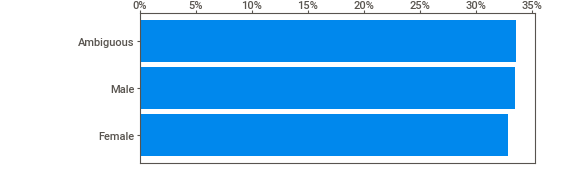
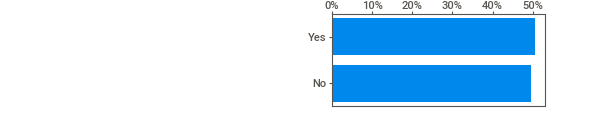
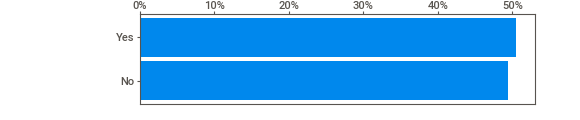
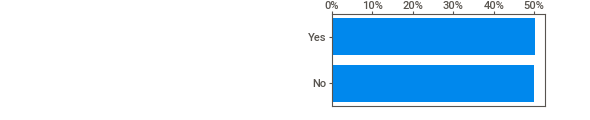
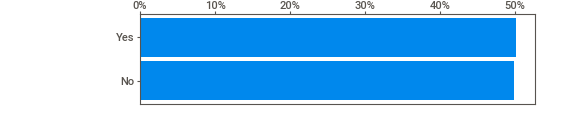
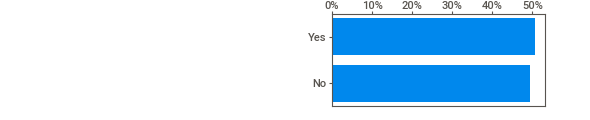
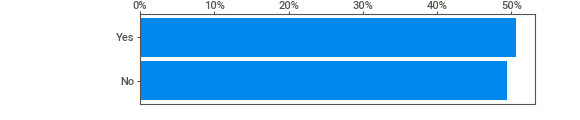
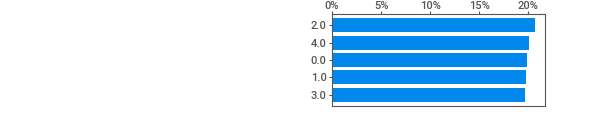
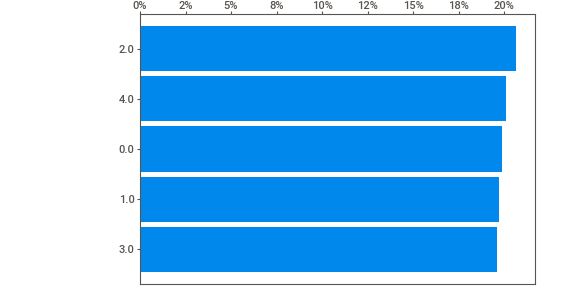
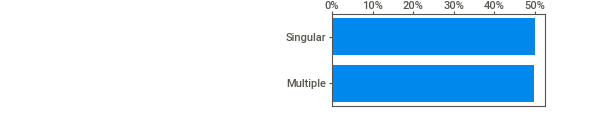
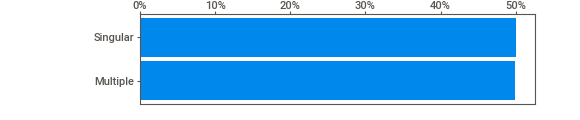
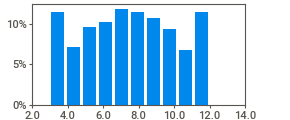
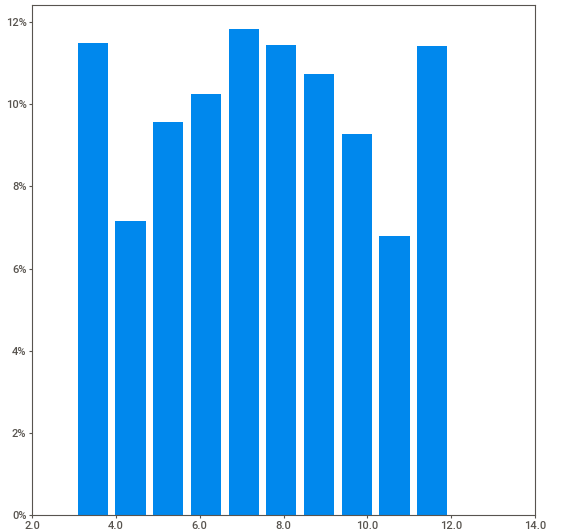
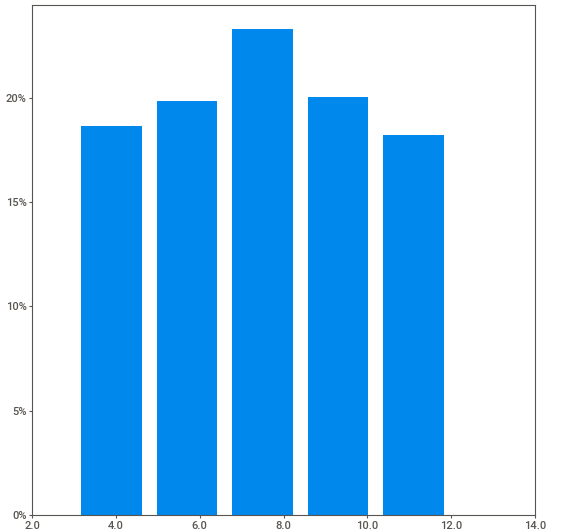
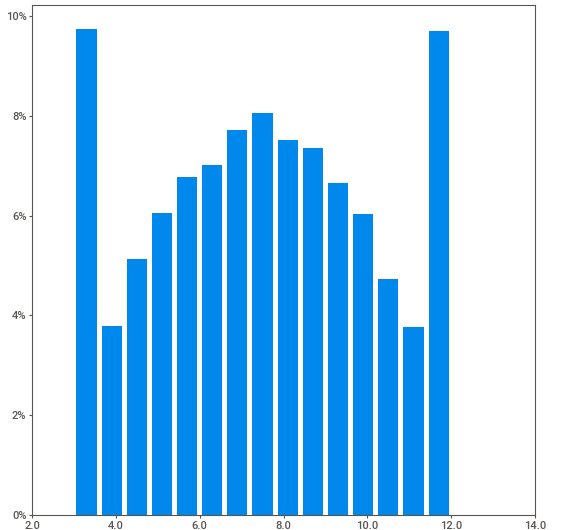
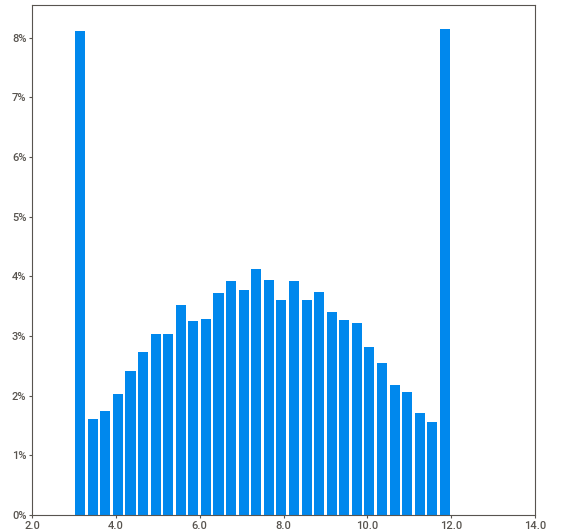
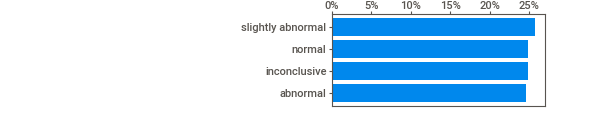
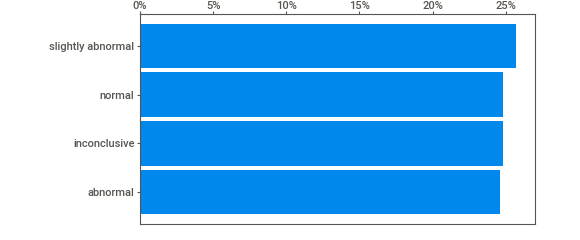
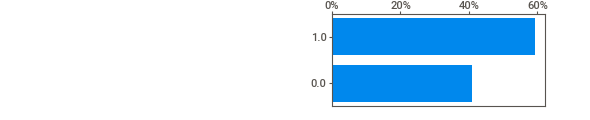
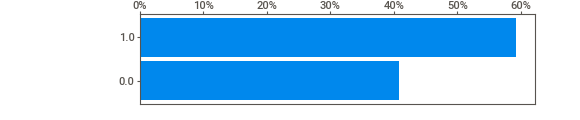
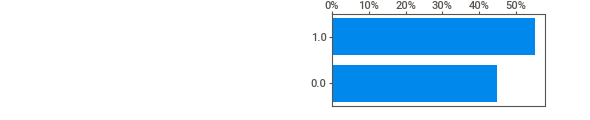
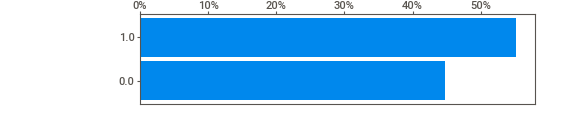
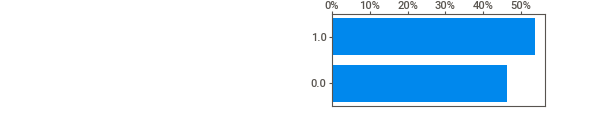
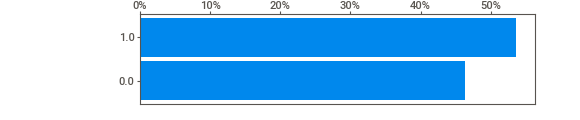
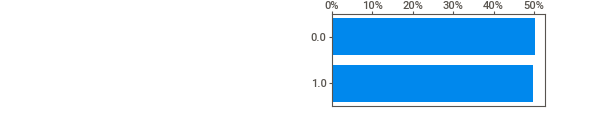
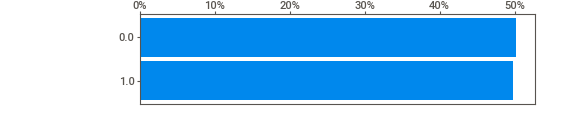
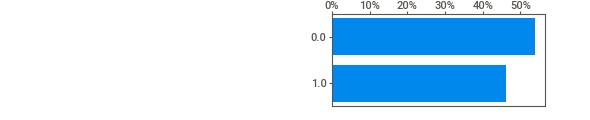
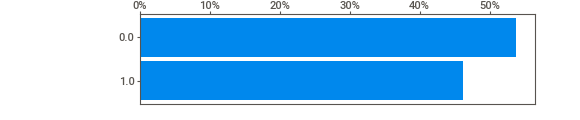
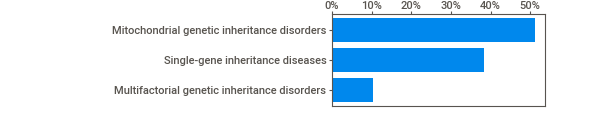
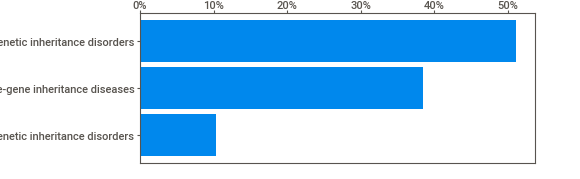
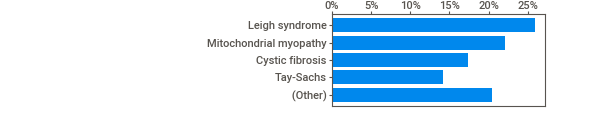
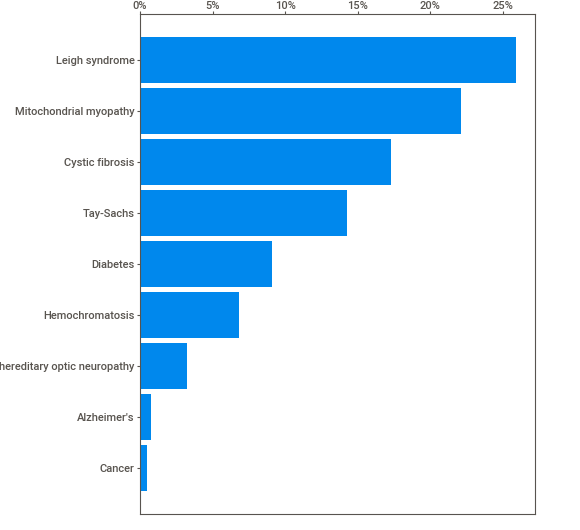
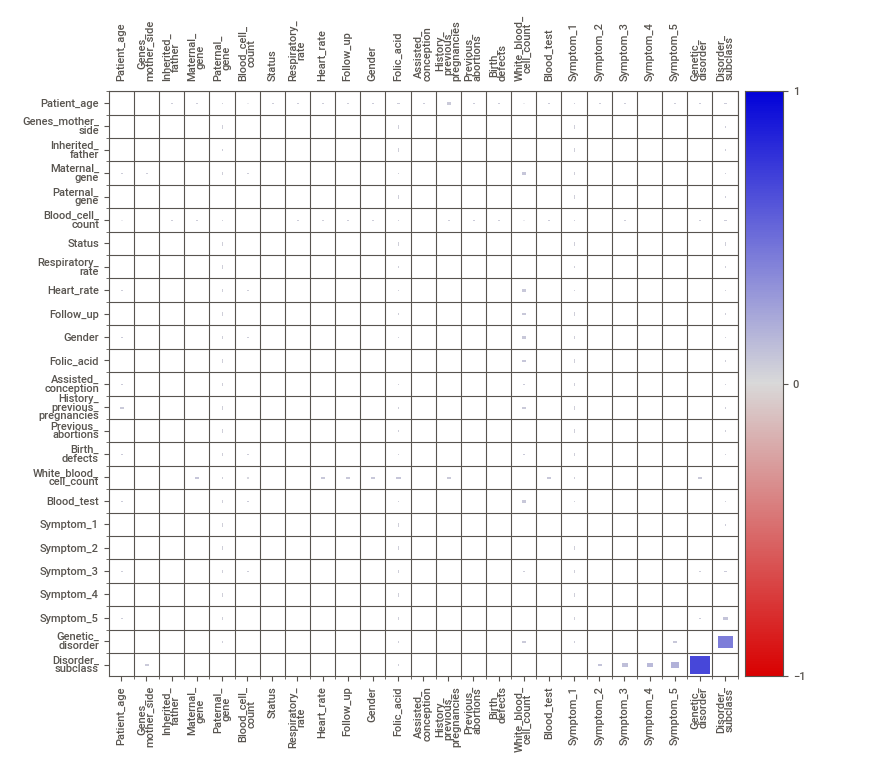
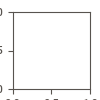

In [37]:
my_report.show_notebook()